## Asteroglitch example

With this module, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [257]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDiagonalNormal, Trace_ELBO
from numpyro.infer.reparam import CircularReparam

from asterion.models import GlitchModel, estimate_n, Model, get_n_max
from asterion.inference import Inference
from asterion.gp import GP, SquaredExponential

from corner import corner

import os

## Data

Import stellar evolutionary track.

In [3]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

filename  model_number  evol_stage  initial_mass  initial_Yinit  \
0  profile4           152           0           1.0           0.26   
1  profile5           153           0           1.0           0.26   
2  profile6           154           0           1.0           0.26   
3  profile7           155           0           1.0           0.26   
4  profile8           156           0           1.0           0.26   

   initial_Zinit  initial_feh  initial_MLT  initial_fov  star_mass  ...  \
0       0.013153          0.0          2.1            0        1.0  ...   
1       0.013153          0.0          2.1            0        1.0  ...   
2       0.013153          0.0          2.1            0        1.0  ...   
3       0.013153          0.0          2.1            0        1.0  ...   
4       0.013153          0.0          2.1            0        1.0  ...   

         E_0_31    E_0_32    E_0_33    E_0_34    E_0_35    E_0_36    E_0_37  \
0  1.216230e-06  0.000002  0.000006  0.000279  0.000014  0.000003  0.000002   
1  1.070235e-06  0.000002  0.000004  0.000047  0.000027  0.000004  0.000002   
2  9.770822e-07  0.000002  0.000003  0.000022  0.000059  0.000005  0.000002   
3  9.140089e-07  0.000001  0.000003  0.000014  0.000159  0.000006  0.000002   
4  8.694409e-07  0.000001  0.000002  0.000010  0.000672  0.000007  0.000002   

     E_0_38        E_0_39        E_0_40  
0  0.000001  8.677974e-07  7.314938e-07  
1  0.000001  8.865659e-07  7.333283e-07  
2  0.000001  9.058076e-07  7.371980e-07  
3  0.000001  9.237271e-07  7.414930e-07  
4  0.000001  9.400169e-07  7.457830e-07  

[5 rows x 110 columns]

In [8]:
model_number = 708

In [10]:
profile = track.loc[track['model_number']==model_number].iloc[0]

Choose a star from the evolutionary track.

Extract modes from star.

In [11]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

In [12]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

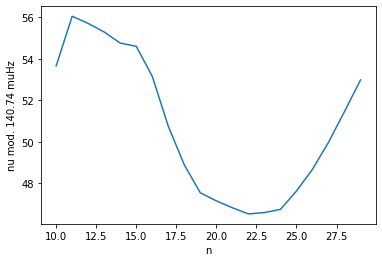

In [414]:
dnu = delta_nu_fit*0.96
plt.plot(n, nu%dnu)
plt.xlabel('n')
plt.ylabel(f'nu mod. {dnu:.2f} muHz')

## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameters `alpha` and `epsilon`, but by default these are fairly uninformative.

In [74]:
delta_nu = [dnu, 1.0]
nu_max = [nu_max_sca, 0.05*nu_max_sca]

In [16]:
from __future__ import annotations

import math

import numpy as np

import jax
import jax.numpy as jnp

from jax import random

import numpyro
import numpyro.distributions as dist

from numpyro.infer.reparam import CircularReparam, Reparam
from numpyro import handlers
from numpyro.primitives import CondIndepStackFrame, plate

from typing import Union, Optional, Callable, Dict, ClassVar, Any
from asterion.typing import Array1D, Array2D, Array3D
from asterion.models import dimension

In [382]:
class GlitchModel(Model):
    """Model the glitch in the asteroseismic radial mode frequencies.

    Args:
        delta_nu: Two elements containing the respective prior mean and standard 
            deviation for the large frequency separation.
        nu_max: Two elements containing the respective prior mean and standard
            deviation for the frequency at maximum power.
        epsilon: Two elements containing the respective prior mean and standard
            deviation for the asymptotic phase term. Default is [1.3, 0.2] which is
            suitable for main sequence solar-like oscillators.
        alpha: Two elements containing the respective prior mean and standard
            deviation for the asymptotic curvature term. Default is [0.0015, 0.002]
            which is suitable for most solar-like oscillators.
        nu: Locations of the l=0 (radial) stellar pulsation modes. Null data may be
            passed as NaN. The shape of nu should be (num_orders,) or 
            (N, num_orders) for N stars in the model.
        nu_err: The observational uncertainty for each element of nu. Null data may be
            passed as NaN. Default is None, for which only a star-by-star model
            error is inferred and observational uncertainty is assumed to be zero.
        n: The observers radial order of each mode in nu. Default is None and n is
            inferred from num_orders.
        num_orders: The number of radial orders to model. The observers n is inferred from
            the priors for delta_nu, nu_max and epsilon. Default is None, and
            num_orders is inferred from the length of the final dimension of nu.
        num_pred: The number of predictions to make in the range of n. Default
            is 200.
    """
    reparam = {
        "phi_he": CircularReparam(),
        "phi_cz": CircularReparam(),
    }
    circ_var_names = [
        "phi_he",
        "phi_cz"
    ]

    def __init__(
        self,
        name: Union[str, Array1D[str]],
        delta_nu: Array1D[float],
        nu_max: Array1D[float],
        epsilon: Array1D[float]=None,
        *,
        nu: Union[Array1D[float], Array2D[float]],
        nu_err: Optional[Union[Array1D[float], Array2D[float]]]=None, 
        n: Optional[Array1D[int]]=None,
        num_orders: Optional[int]=None,
        num_pred: int=200,
        regularization: float=1e-6,
    ):

        self._delta_nu = np.array(delta_nu)
        self._nu_max = np.array(nu_max)
        self._epsilon = np.array([1.3, 0.2]) if epsilon is None else np.array(epsilon)
        self._log_alpha = np.array([-7.0, 1.0])
        
        super().__init__(
            name, n, nu=nu, nu_err=nu_err,
        )

        self.num_pred = num_pred
        self.n_pred = np.linspace(self.n[0], self.n[-1], num_pred)
        self.dimensions["n_pred"] = dimension(
            "n_pred", self.num_pred, coords=self.n_pred
        )

        # self.num_stars = 1 if len(self.name.shape) == 0 else self.name.shape[0]
        # self.num_orders = self.n.shape[0]
        # self.name = np.broadcast_to(self.name, (self.num_stars,))
        # self.n = np.broadcast_to(self.n, (self.num_orders,))

        # shape = (self.num_stars, self.num_orders)
        # self.nu = np.broadcast_to(self.nu, shape)
        # self.nu_err = np.broadcast_to(self.nu_err, shape)
        # self.obs_mask = np.broadcast_to(self.obs_mask, shape)
    
        # self.dimensions = {
        #     'name': dimension('name', self.num_stars, coords=self.name),
        #     'n': dimension('n', self.num_orders, coords=self.n)
        # }
            
    def _model(self, n, n_pred=None, nu=None, nu_err=None):
        # GP Hyperparameters
        var = 4.0
        length = 10.0
        
        log_numax = jnp.log10(self._nu_max[0])
        
        epsilon = numpyro.sample("epsilon", dist.Normal(*self._epsilon))
        alpha = numpyro.sample("alpha", dist.LogNormal(*self._log_alpha))
        delta_nu = numpyro.sample("delta_nu", dist.Normal(*self._delta_nu))
        nu_max = numpyro.sample("nu_max", dist.Normal(*self._nu_max))

        log_b0 = numpyro.sample("log_b0", dist.Normal(-1.10 - 0.35*log_numax, 0.1))
        b0 = numpyro.deterministic("b0", 10**log_b0)
        log_b1 = numpyro.sample("log_b1", dist.Normal(0.719 - 2.14*log_numax, 0.1))
        b1 = numpyro.deterministic("b1", 10**log_b1)

        log_tau_he = numpyro.sample("log_tau_he", dist.Normal(0.44 - 1.03*log_numax, 0.01))
        tau_he = numpyro.deterministic('tau_he', 10**log_tau_he)
        phi_he = numpyro.sample("phi_he", dist.VonMises(0.0, 0.1))

        log_c0 = numpyro.sample("log_c0", dist.Normal(2*log_numax - 1.0, 0.1))
        c0 = numpyro.deterministic("c0", 10**log_c0)

        log_tau_cz = numpyro.sample("log_tau_cz", dist.Normal(0.77 - 0.99*log_numax, 0.01))
        tau_cz = numpyro.deterministic('tau_cz', 10**log_tau_cz)

        phi_cz = numpyro.sample("phi_cz", dist.VonMises(0.0, 0.1))

        noise = numpyro.sample("noise", dist.HalfNormal(0.1), obs=nu_err)

        def mean(n):
            n_max = get_n_max(epsilon, delta_nu, nu_max)
            _nu = delta_nu * (n + epsilon + 0.5*alpha*(n - n_max)**2)
            return _nu
            dnu_he = b0 * _nu * jnp.exp(- b1 * _nu**2) * jnp.sin(4*np.pi*tau_he*_nu + phi_he)
            dnu_cz = c0 / _nu**2 * jnp.sin(4*np.pi*tau_cz*_nu + phi_cz)
            return _nu + dnu_he + dnu_cz

#         kernel = SquaredExponential(var, length)
#         gp = GP(kernel, mean=mean)

#         gp.sample('nu', n, noise=noise, obs=nu)
        err = numpyro.sample("err", dist.HalfNormal(0.1))
        numpyro.sample('nu', dist.Normal(mean(n), err), obs=nu)
        
        if n_pred is not None:
#             gp.predict('nu_pred', n_pred)
            numpyro.sample('nu_pred', dist.Normal(mean(n_pred), err))

In [383]:
model = GlitchModel('model_star', delta_nu, nu_max, epsilon=[1.2, 0.2], nu=nu, n=n)

In [384]:
n_pred = np.linspace(n.min(), n.max(), 250)

rng_key = random.PRNGKey(0)

prior_predictive = Predictive(model._model, num_samples=1000)
prior_pred = prior_predictive(rng_key, n, n_pred, nu_err=0.0)

In [385]:
nu_prior = np.squeeze(prior_pred['nu'])
nu_prior.shape

(1000, 20)

In [386]:
nu_fit = np.linspace(nu.min(), nu.max(), 150)[:, None]
dnu_he = prior_pred['b0'] * nu_fit * np.exp(- prior_pred['b1']*nu_fit**2) * \
        np.sin(4*np.pi*prior_pred['tau_he']*nu_fit + prior_pred['phi_he'])

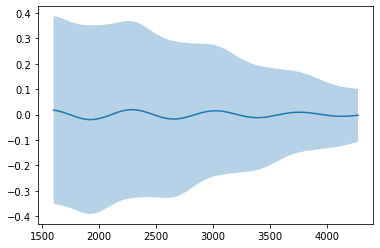

In [387]:
mean = (dnu_he).mean(axis=1)
sd = (dnu_he).std(axis=1)

plt.plot(nu_fit[:, 0], mean)
plt.fill_between(nu_fit[:, 0], mean-sd, mean+sd, alpha=0.33)

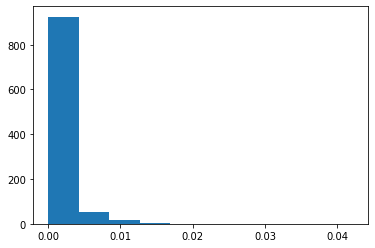

In [402]:
plt.hist(np.squeeze(prior_pred['alpha']));

In [389]:
dnu_cz = prior_pred['c0'] / nu_fit**2 * \
        np.sin(4*np.pi*prior_pred['tau_cz']*nu_fit + prior_pred['phi_cz'])

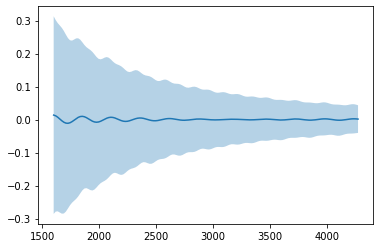

In [390]:
mean = dnu_cz.mean(axis=1)
sd = dnu_cz.std(axis=1)

plt.plot(nu_fit[:, 0], mean)
plt.fill_between(nu_fit[:, 0], mean-sd, mean+sd, alpha=0.33)

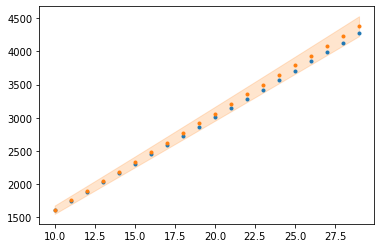

In [391]:
plt.plot(n, nu, '.')
mean = nu_prior.mean(axis=0)
sd = nu_prior.std(axis=0)
plt.plot(n, mean, '.')
plt.fill_between(n, mean-sd, mean+sd, alpha=0.2, color='C1')

In [392]:
reparam_model = handlers.reparam(model._model, model.reparam)

In [407]:
rng_key = random.PRNGKey(0)
sampler = NUTS(reparam_model, target_accept_prob=0.95)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=5)
mcmc.run(rng_key, n, nu=nu, nu_err=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [408]:
samples = mcmc.get_samples()

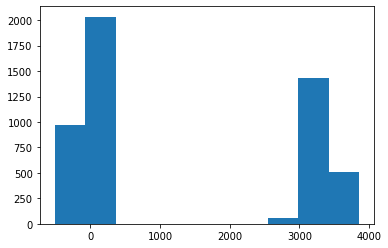

In [409]:
plt.hist(np.squeeze(samples['nu_max']));

In [410]:
rng_key = random.PRNGKey(0)

post_predictive = Predictive(model._model, samples)
post_pred = post_predictive(rng_key, n, n_pred, nu_err=0.0)

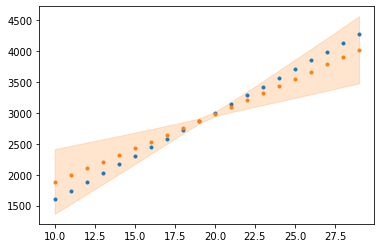

In [411]:
nu_samples = post_pred['nu']

plt.plot(n, nu, '.')
mean = nu_samples.mean(axis=0)
sd = nu_samples.std(axis=0)
plt.plot(n, mean, '.')
plt.fill_between(n, mean-sd, mean+sd, alpha=0.2, color='C1')

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [11]:
infer = Inference(model, num_warmup=2000, num_samples=2000, seed=42)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [12]:
infer.prior_predictive()

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

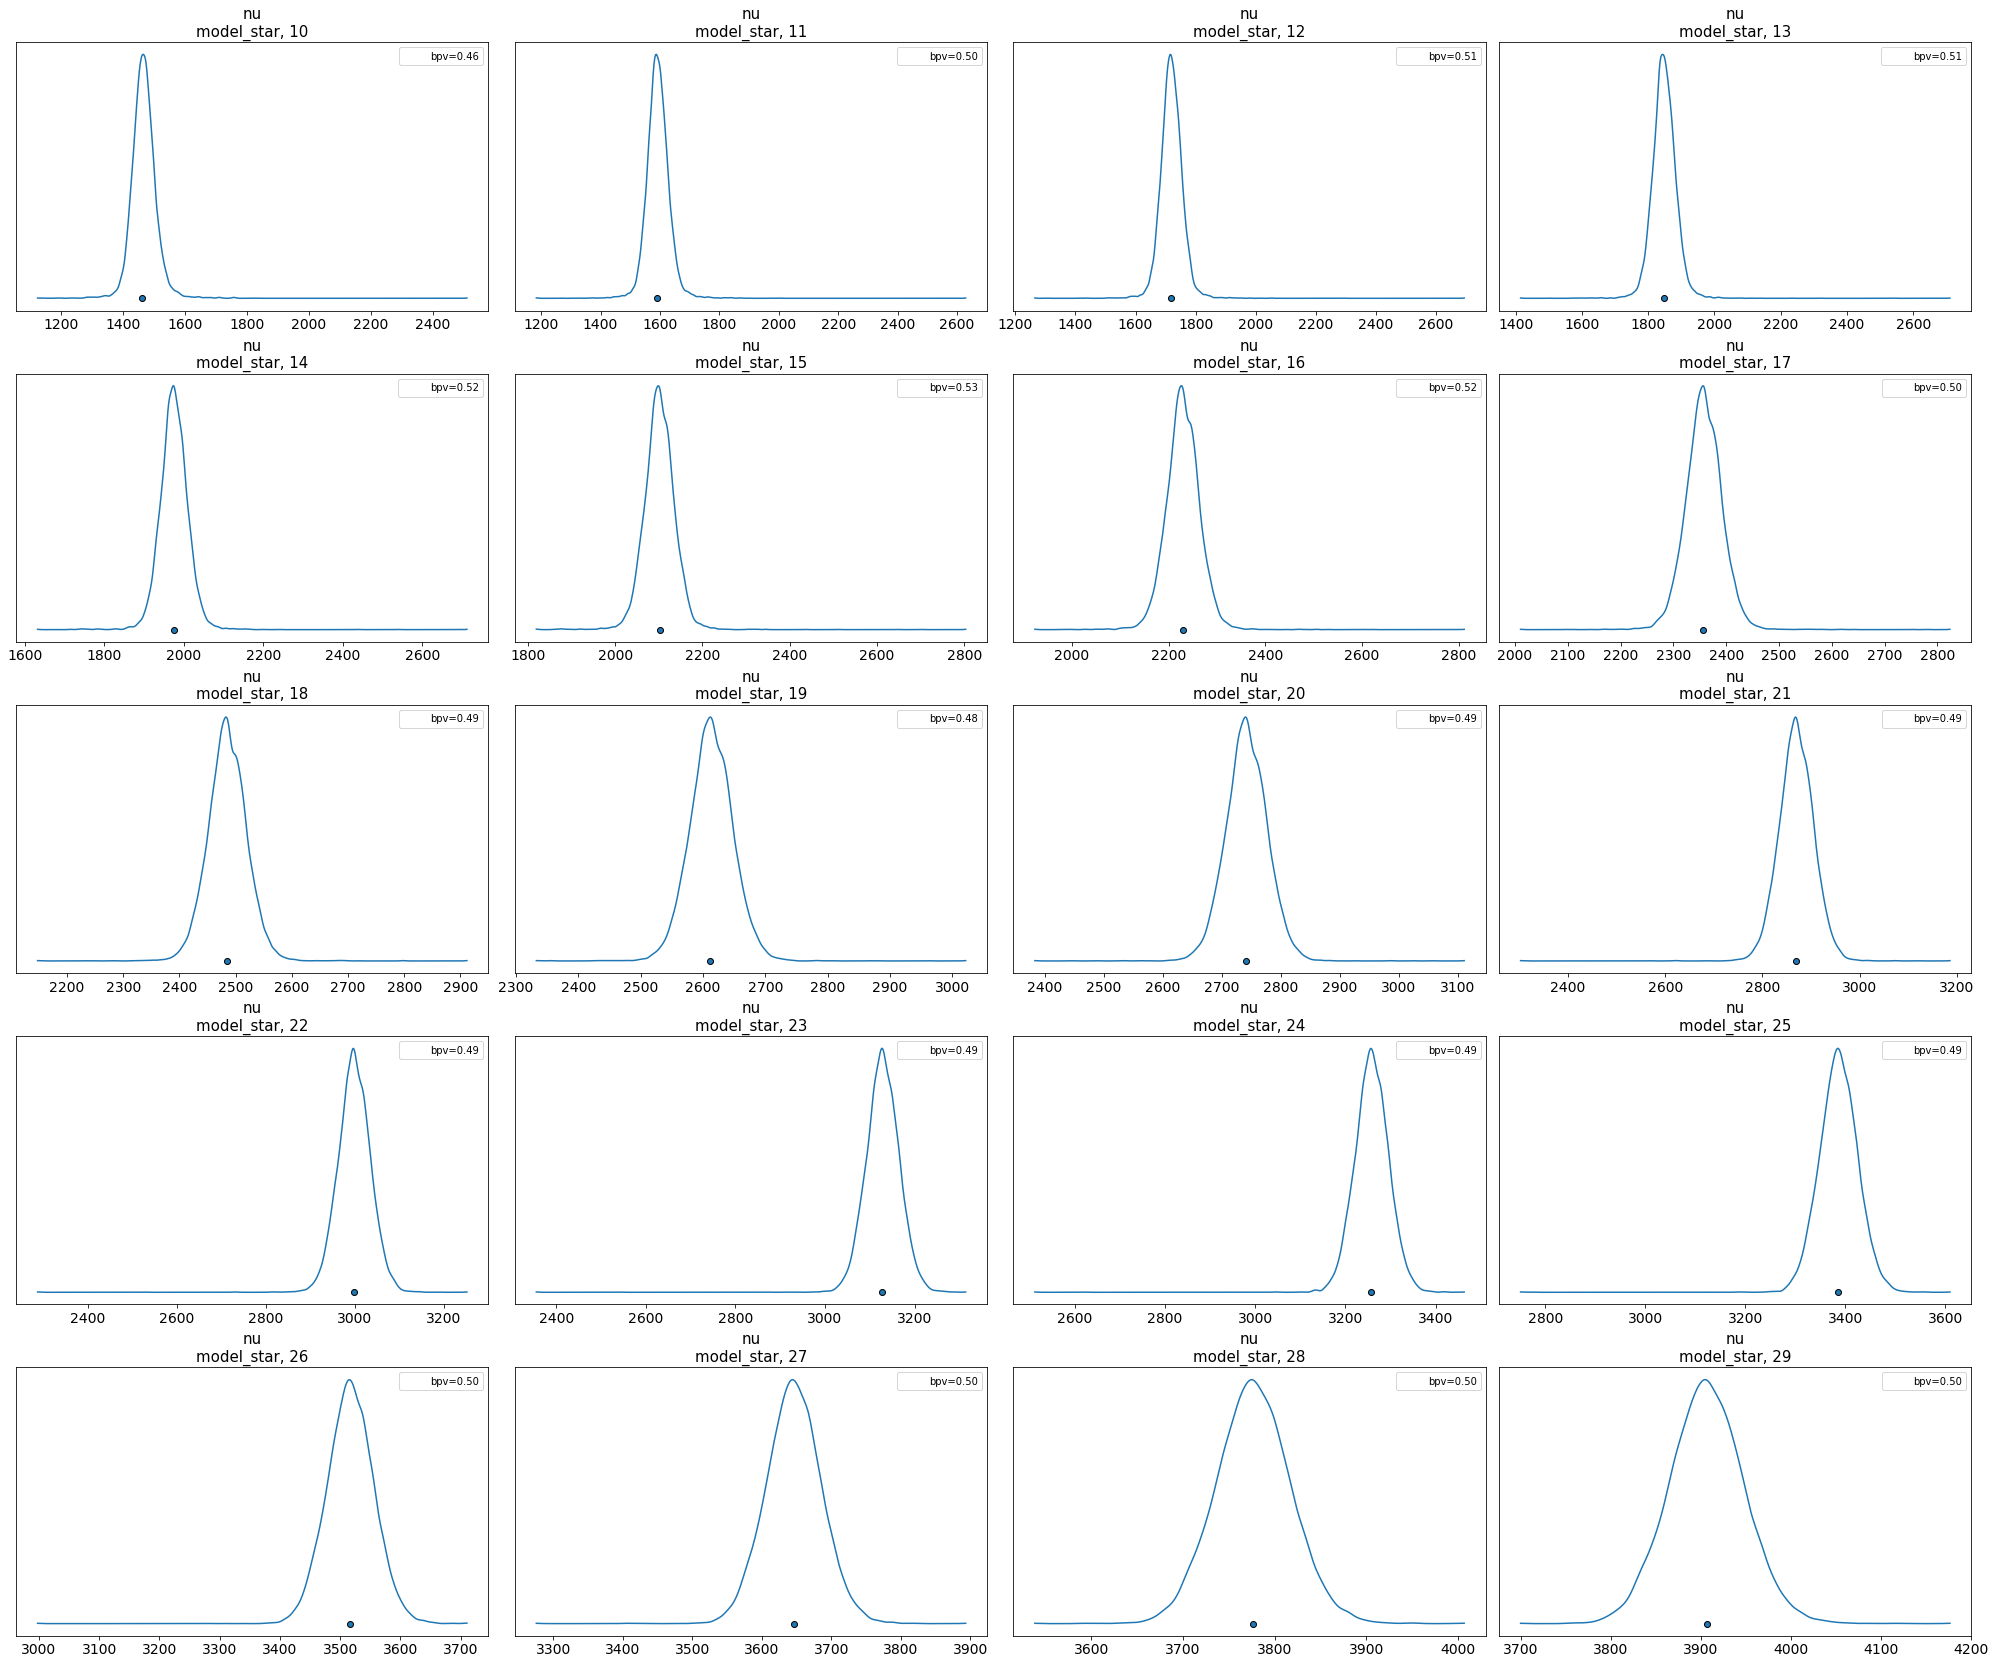

In [13]:
az.plot_bpv(infer.data, var_names=['nu'], group='prior', kind='t_stat', flatten=['chain', 'draws']);

#### Sample posterior

We sample from the posterior using the `numpyro` NUTS sampler. This should take about a minute.

In [14]:
infer.sample()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Lets have a look at the trace plot for the model parameters.

In [15]:
var_names = ['delta_nu', 'nu_max', 'epsilon', 'alpha', 
             'b0', 'b1', 'tau_he', 'phi_he', 
             'c0', 'tau_cz', 'phi_cz']

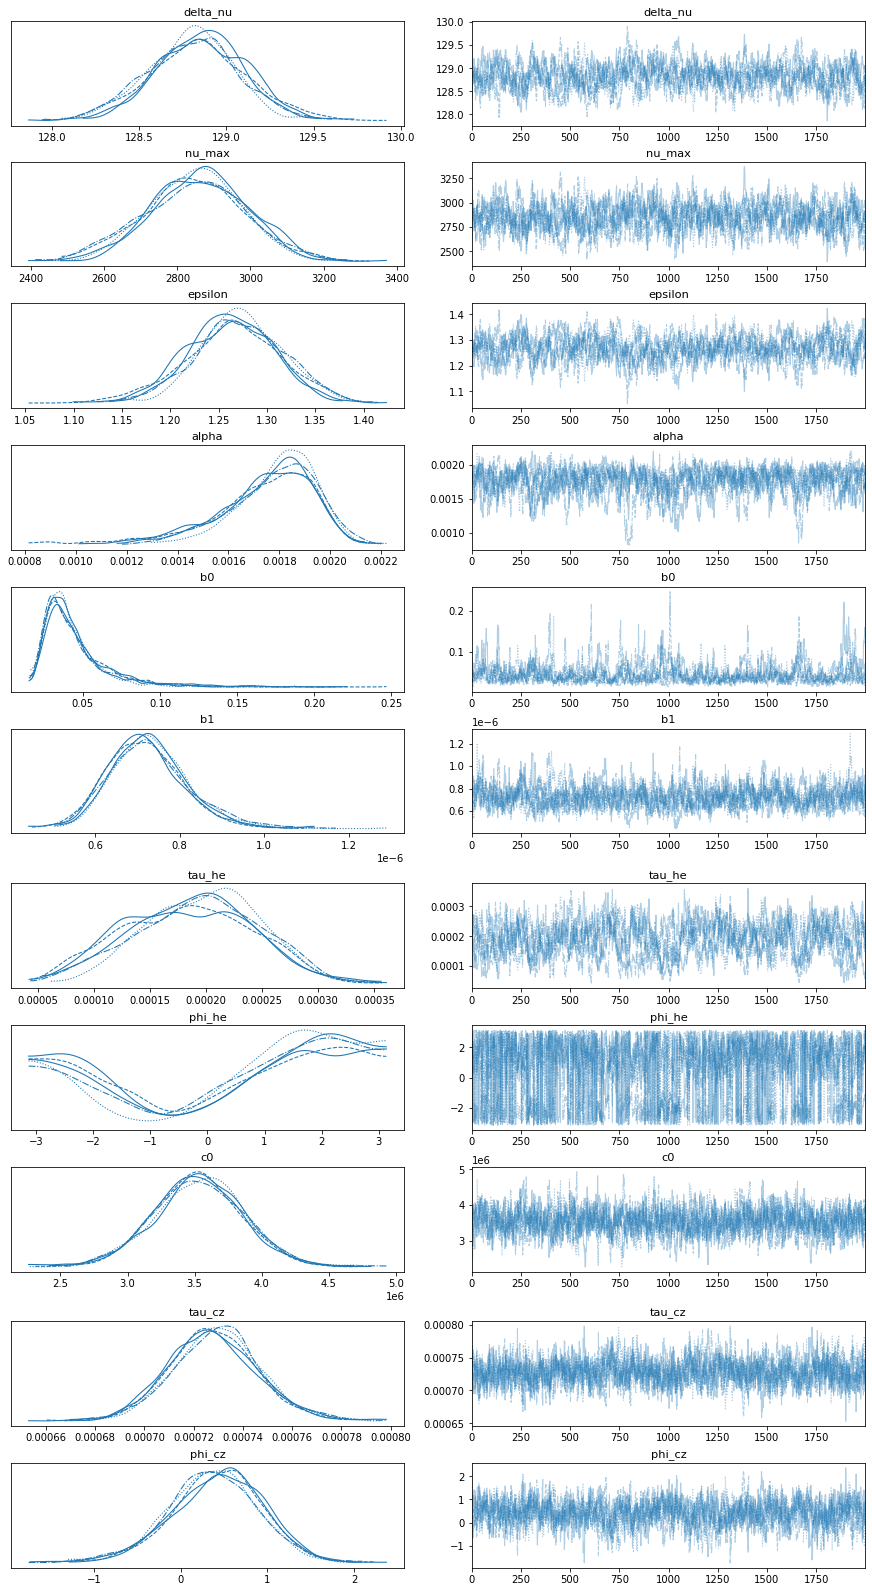

In [17]:
az.plot_trace(infer.data, var_names=var_names);

The data works with the `corner` module too.

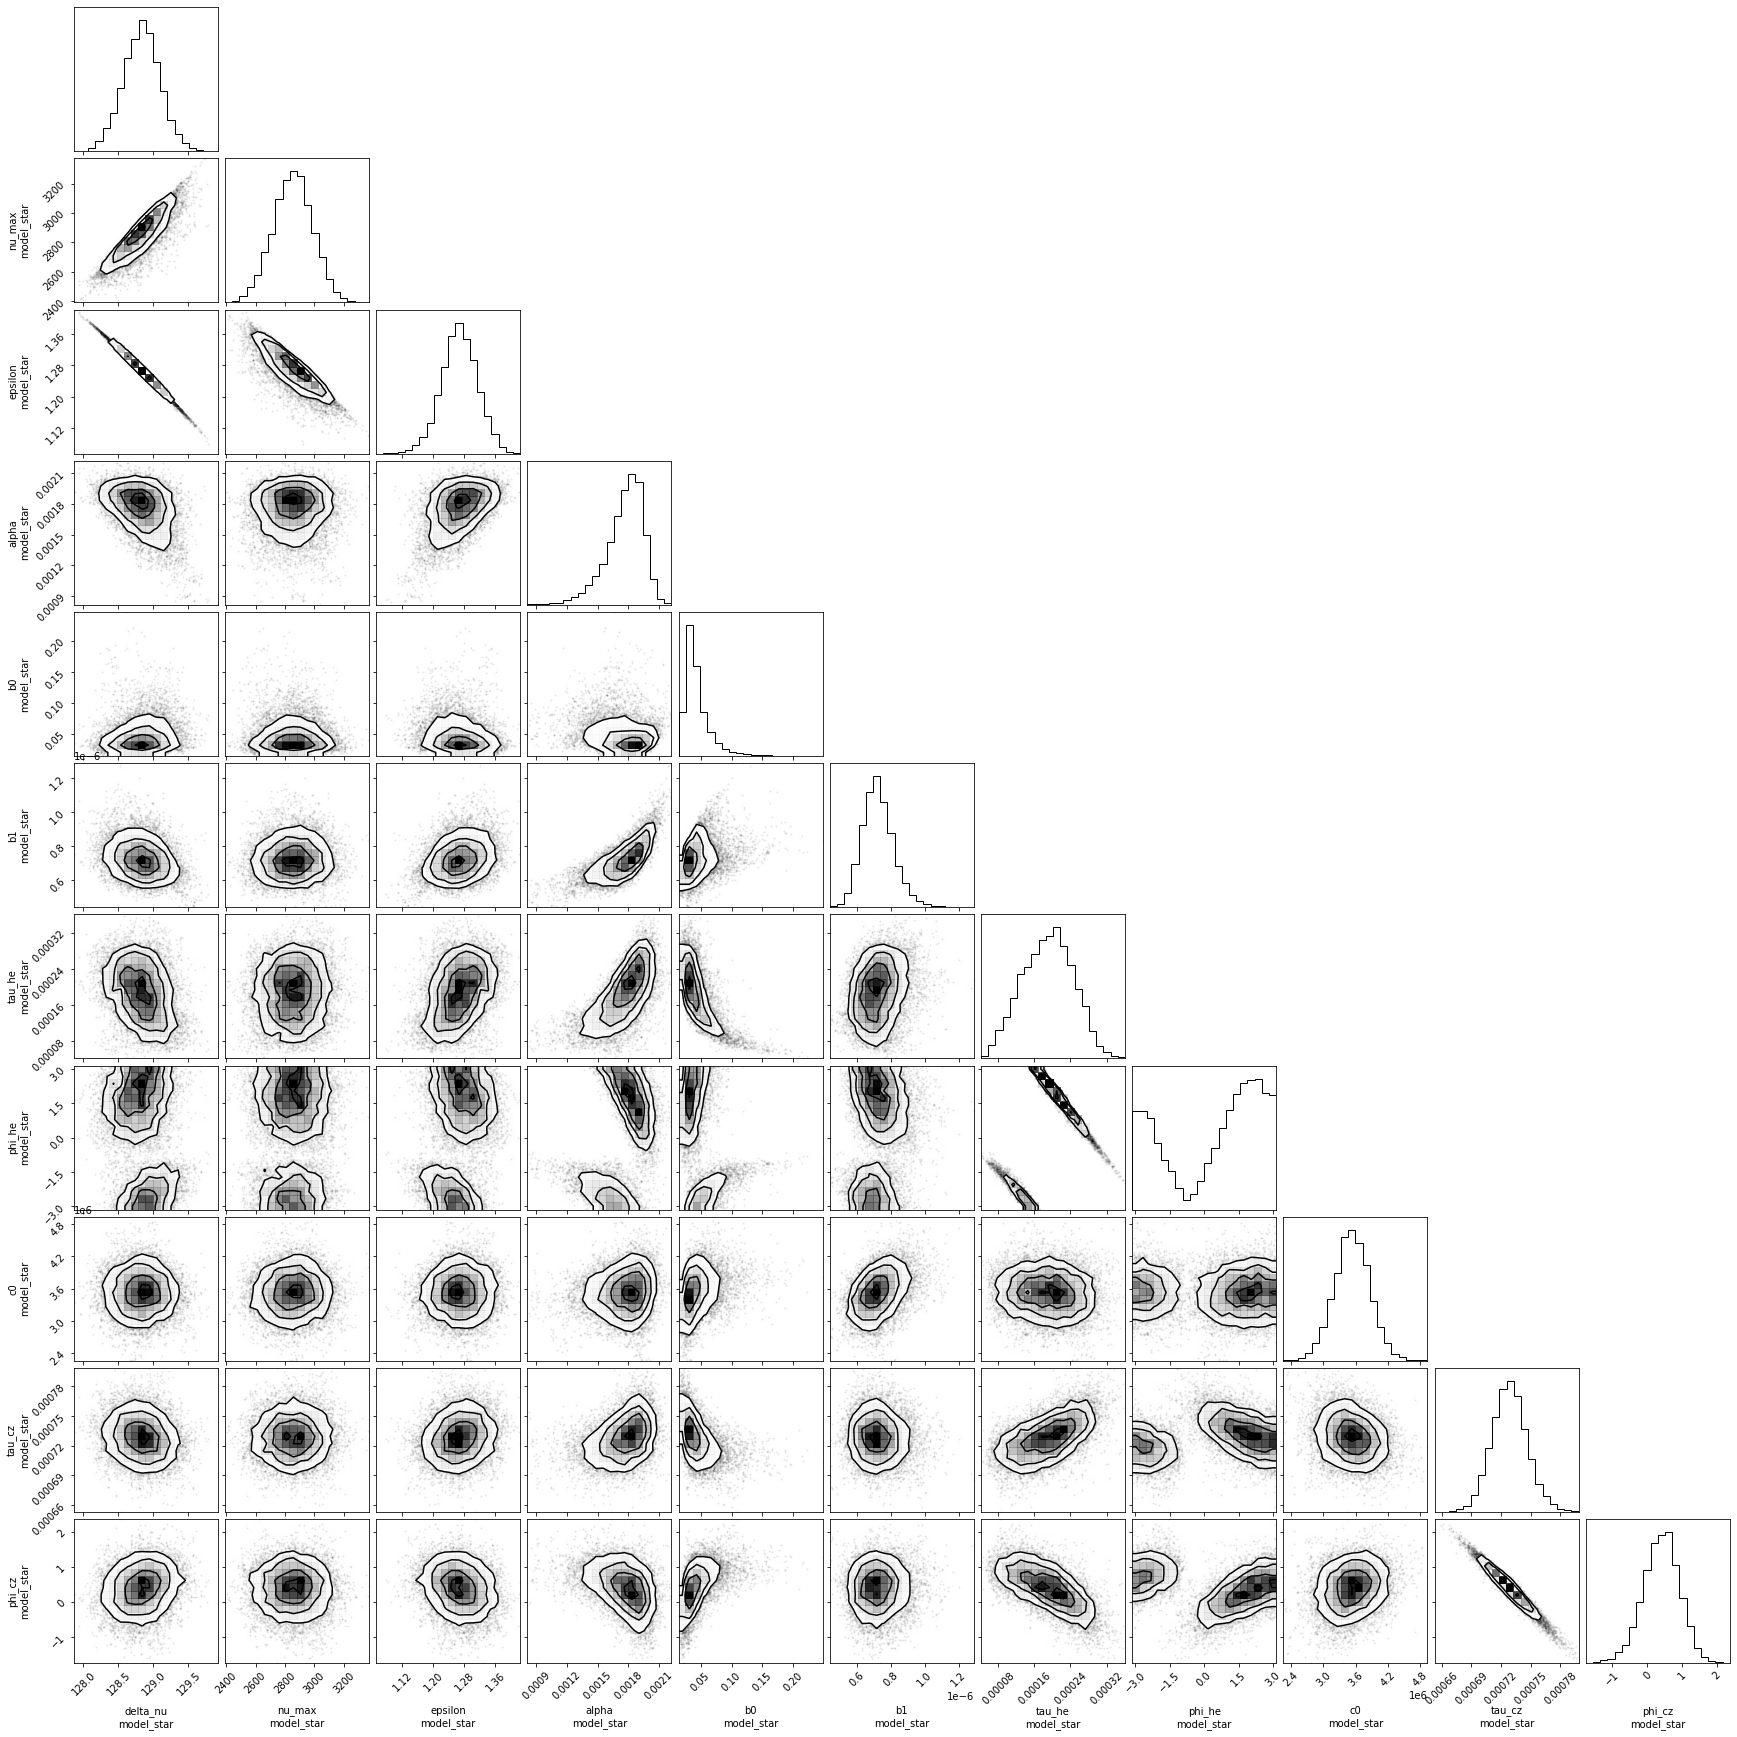

In [18]:
corner(
    infer.data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

#### Posterior predictive check

Finally, we do a posterior predictive check to see if our results make sense.

In [19]:
infer.posterior_predictive()

The dots are the observed values and the curves are the posterior estimates. Looks pretty good.

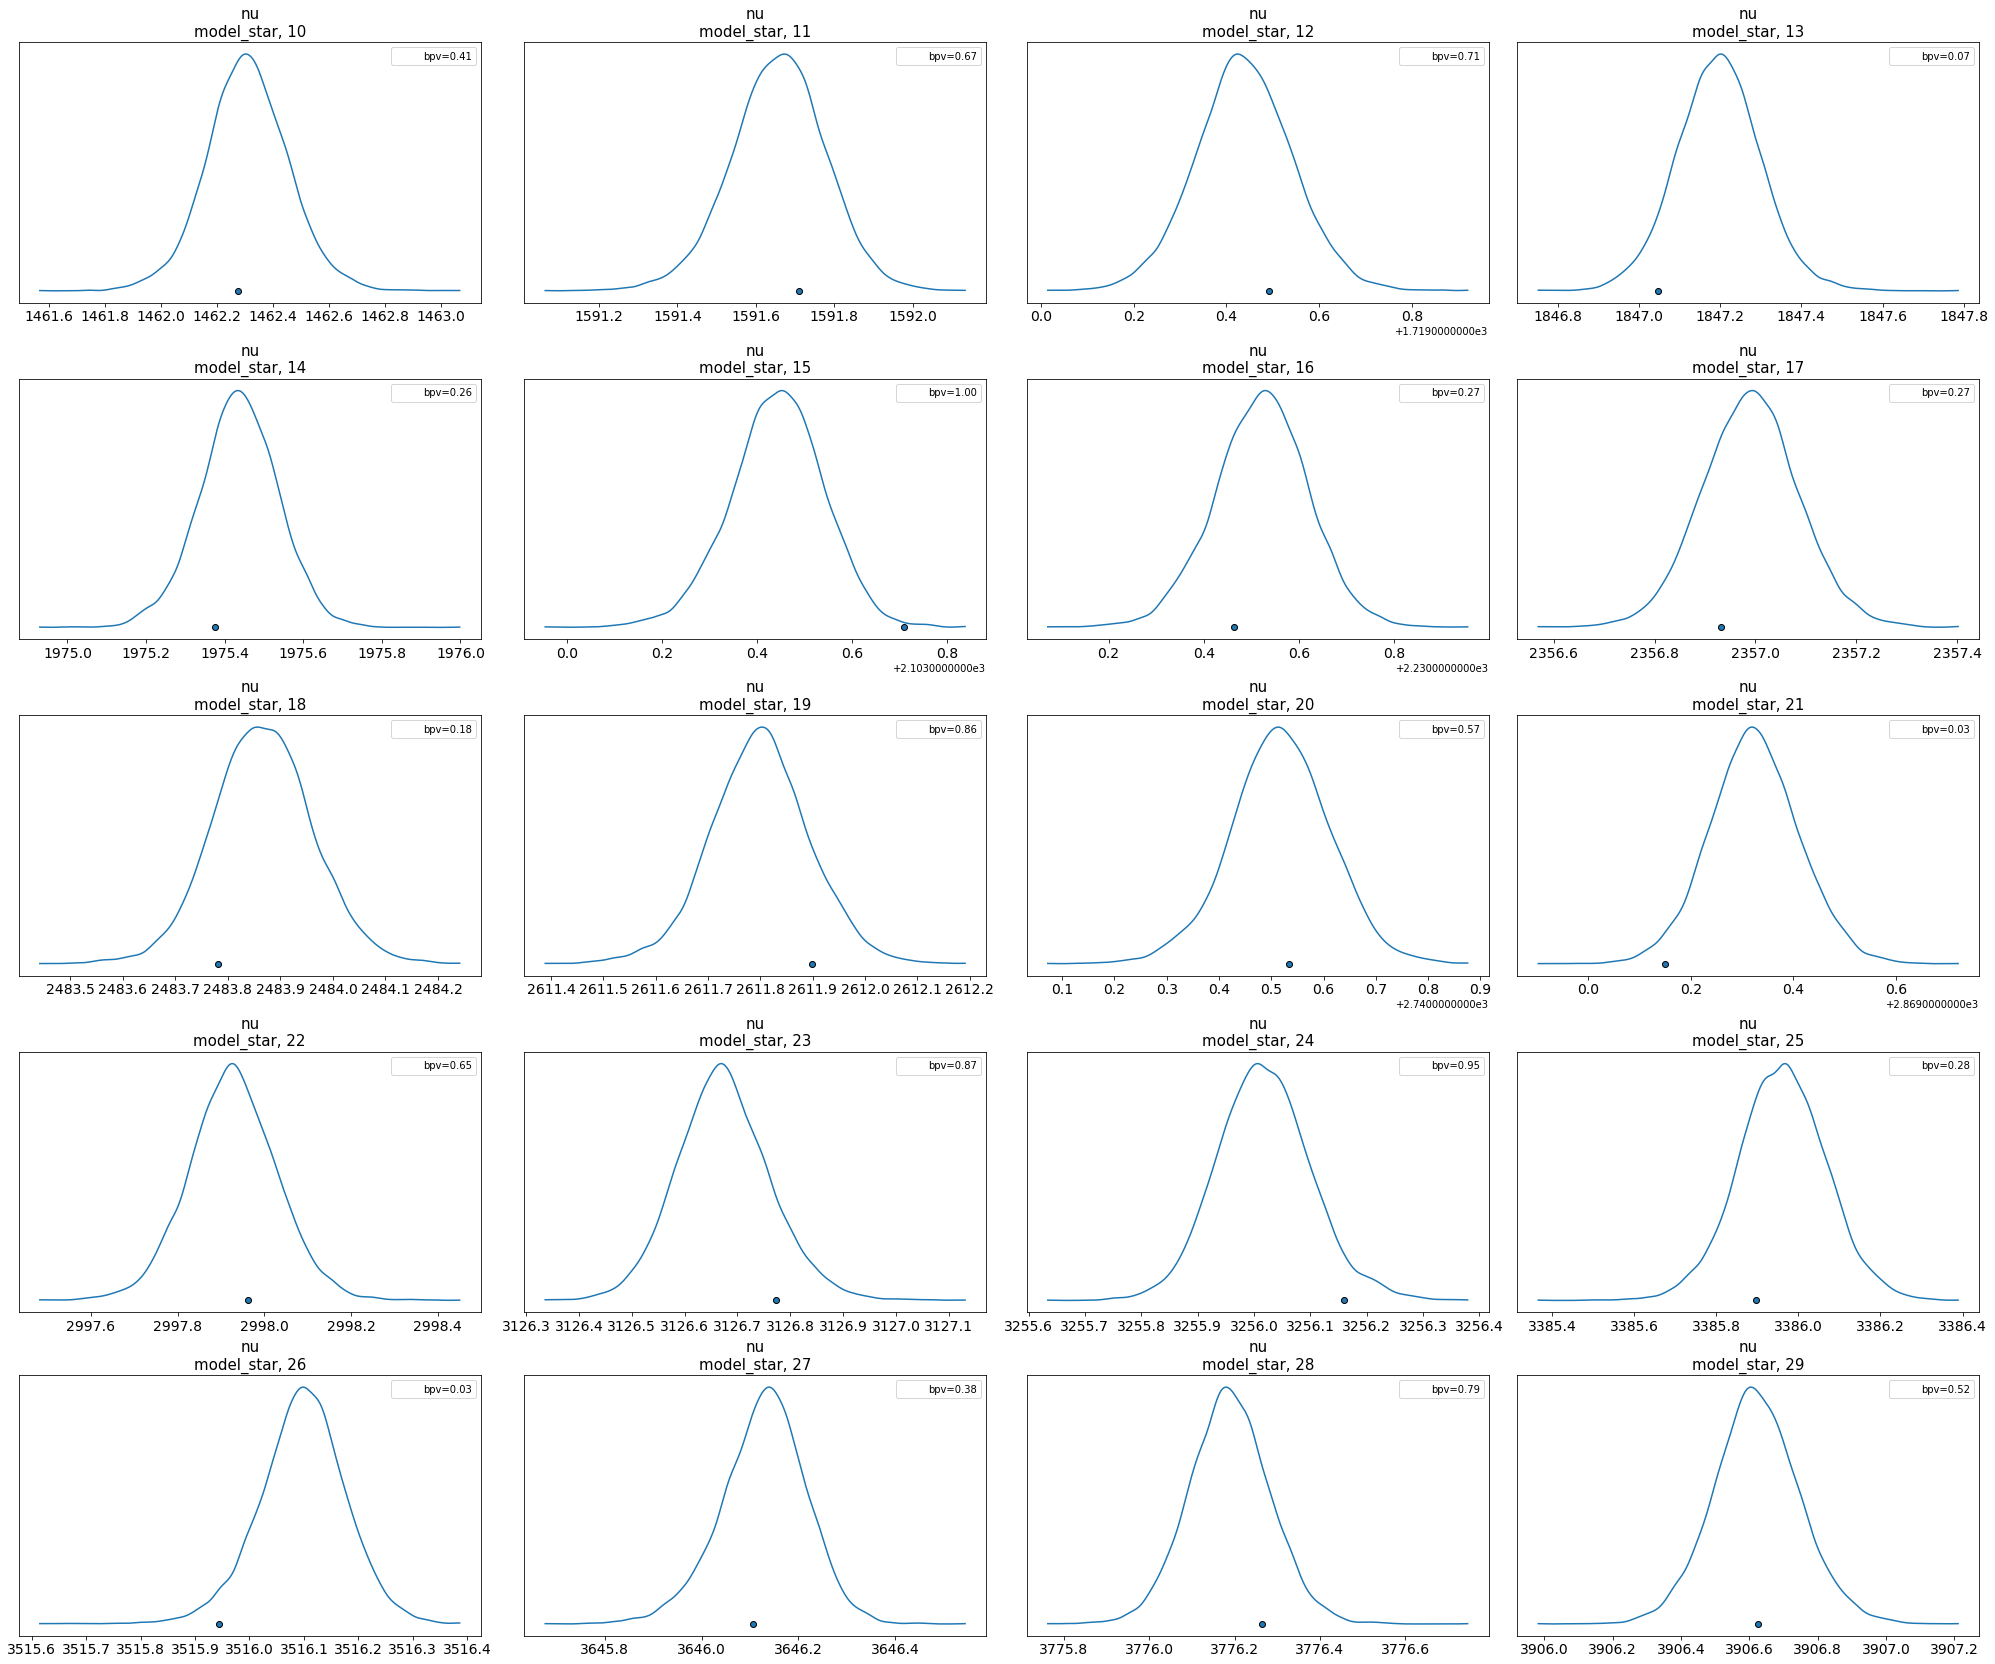

In [20]:
az.plot_bpv(infer.data, var_names=['nu'], group='posterior', kind='t_stat', flatten=['chain', 'draws']);

Let's check whether our model parameters are prior dominated by comparing the prior_predictive to the posterior

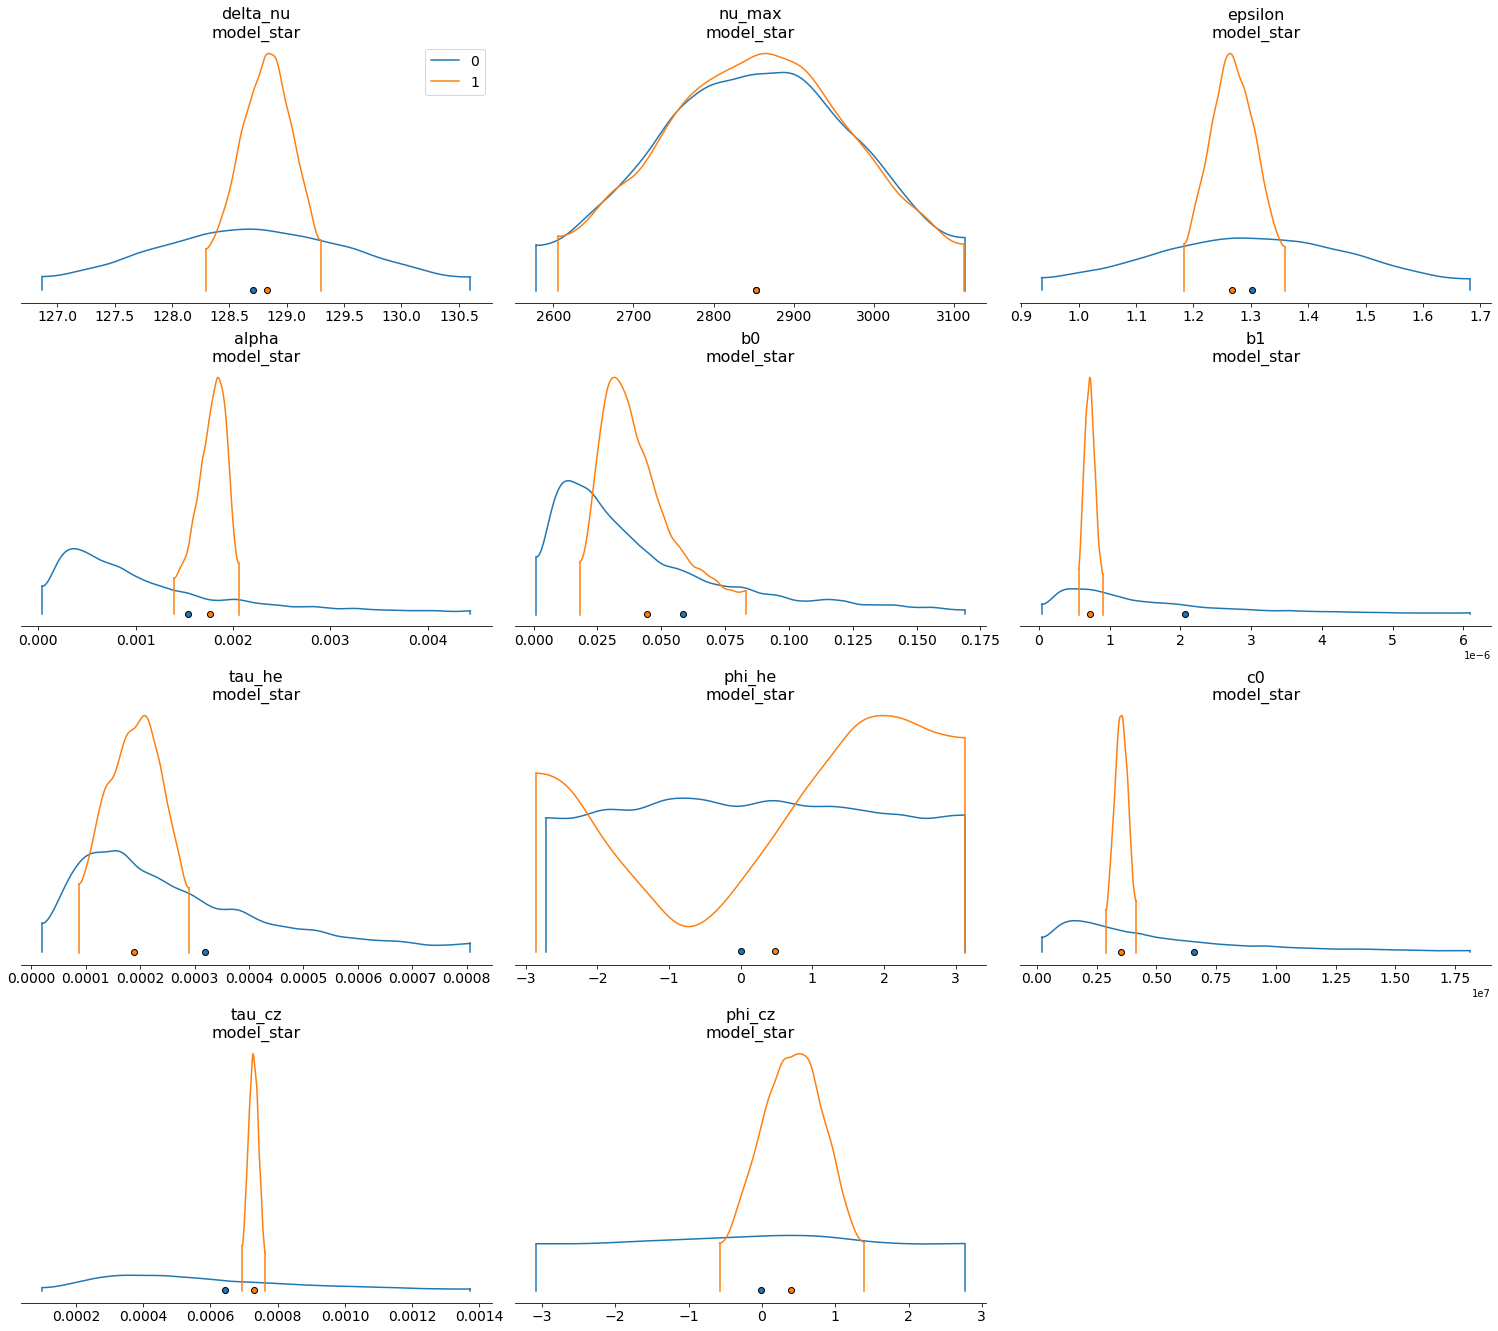

In [23]:
az.plot_density([infer.data.prior_predictive, infer.data.posterior], var_names=var_names);

#### Predictions

Finally, let's make some predictions from our posterior samples. This will be a continuous function of `n`.

In [24]:
infer.predictions()

We can view our inference data interactively.

In [31]:
infer.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data

Let's look at the predictions.

In [136]:
post = infer.data.posterior
post

<xarray.Dataset>
Dimensions:                 (chain: 5, draw: 2000, n: 20, name: 1, phi_cz_unwrapped_dim_0: 1, phi_he_unwrapped_dim_0: 1)
Coordinates:
  * chain                   (chain) int64 0 1 2 3 4
  * draw                    (draw) int64 0 1 2 3 4 ... 1995 1996 1997 1998 1999
  * name                    (name) object 'model_star'
  * n                       (n) int64 10 11 12 13 14 15 16 ... 24 25 26 27 28 29
  * phi_cz_unwrapped_dim_0  (phi_cz_unwrapped_dim_0) int64 0
  * phi_he_unwrapped_dim_0  (phi_he_unwrapped_dim_0) int64 0
Data variables: (12/21)
    alpha                   (chain, draw, name) float64 ...
    b0                      (chain, draw, name) float64 ...
    b1                      (chain, draw, name) float64 ...
    c0                      (chain, draw, name) float64 ...
    delta_nu                (chain, draw, name) float64 ...
    delta_tau               (chain, draw, name) float64 ...
    ...                      ...
    phi_cz                  (chain, draw, name) float64 ...
    phi_cz_unwrapped        (chain, draw, phi_cz_unwrapped_dim_0) float64 ...
    phi_he                  (chain, draw, name) float64 ...
    phi_he_unwrapped        (chain, draw, phi_he_unwrapped_dim_0) float64 ...
    tau_cz                  (chain, draw, name) float64 ...
    tau_he                  (chain, draw, name) float64 ...
Attributes:
    created_at:     2021-08-10T15:35:48.797109
    arviz_version:  0.11.2

In [135]:
pred = infer.data.predictions
pred

<xarray.Dataset>
Dimensions:  (chain: 5, draw: 2000, n_pred: 200, name: 1)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * name     (name) object 'model_star'
  * n_pred   (n_pred) float64 10.0 10.1 10.19 10.29 ... 28.71 28.81 28.9 29.0
Data variables:
    dnu_cz   (chain, draw, name, n_pred) float64 ...
    dnu_he   (chain, draw, name, n_pred) float64 ...
    nu       (chain, draw, name, n_pred) float64 ...
    nu_asy   (chain, draw, name, n_pred) float64 ...
    tau_cz   (chain, draw, name) float64 ...
Attributes:
    created_at:     2021-08-10T15:35:48.821964
    arviz_version:  0.11.2

In [137]:
glitch = post["dnu_he"] + post["dnu_cz"]

In [138]:
glitch_pred = pred["dnu_he"] + pred["dnu_cz"]  # Add both glitches

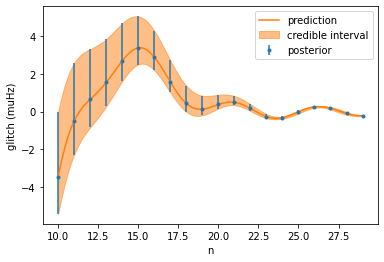

In [139]:
dim = ["chain", "draw"]  # Dimensions to calculate stats over
name = "model_star"      # Name of star to plot

glitch_med = glitch.sel(name=name).median(dim=dim)
upper = glitch.sel(name=name).quantile(.84, dim=dim)
lower = glitch.sel(name=name).quantile(.16, dim=dim)

plt.errorbar(
    glitch["n"], 
    glitch_med,
    yerr=[
        glitch_med-lower,
        upper-glitch_med,
    ],
    fmt='.',
    label='posterior',
)

plt.plot(
    glitch_pred["n_pred"], 
    glitch_pred.sel(name=name).median(dim=dim),
    label='prediction'
)
plt.fill_between(
    glitch_pred["n_pred"], 
    glitch_pred.sel(name=name).quantile(.16, dim=dim),
    glitch_pred.sel(name=name).quantile(.84, dim=dim),
    alpha=0.5,
    color='C1',
    label='credible interval',
)

plt.xlabel('n')
plt.ylabel('glitch (muHz)')
plt.legend();

In [106]:
from asterion.data import save

In [109]:
save(infer.data, 'example.trace')

'example.trace'

## Model with observational error

Synthesise observational error.

In [110]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [111]:
rng = np.random.default_rng(42)

In [112]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [113]:
nu_obs = add_noise(rng, nu, nu_err)

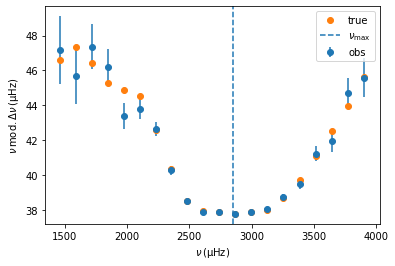

In [114]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [117]:
model = GlitchModel('obs_star', delta_nu, nu_max, nu=nu_obs, nu_err=nu_err, n=n)

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [118]:
infer = Inference(model, num_warmup=2000, num_samples=2000, seed=42)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [119]:
infer.prior_predictive()

You may do the same plots as before.

In [120]:
infer.sample()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [121]:
infer.posterior_predictive()

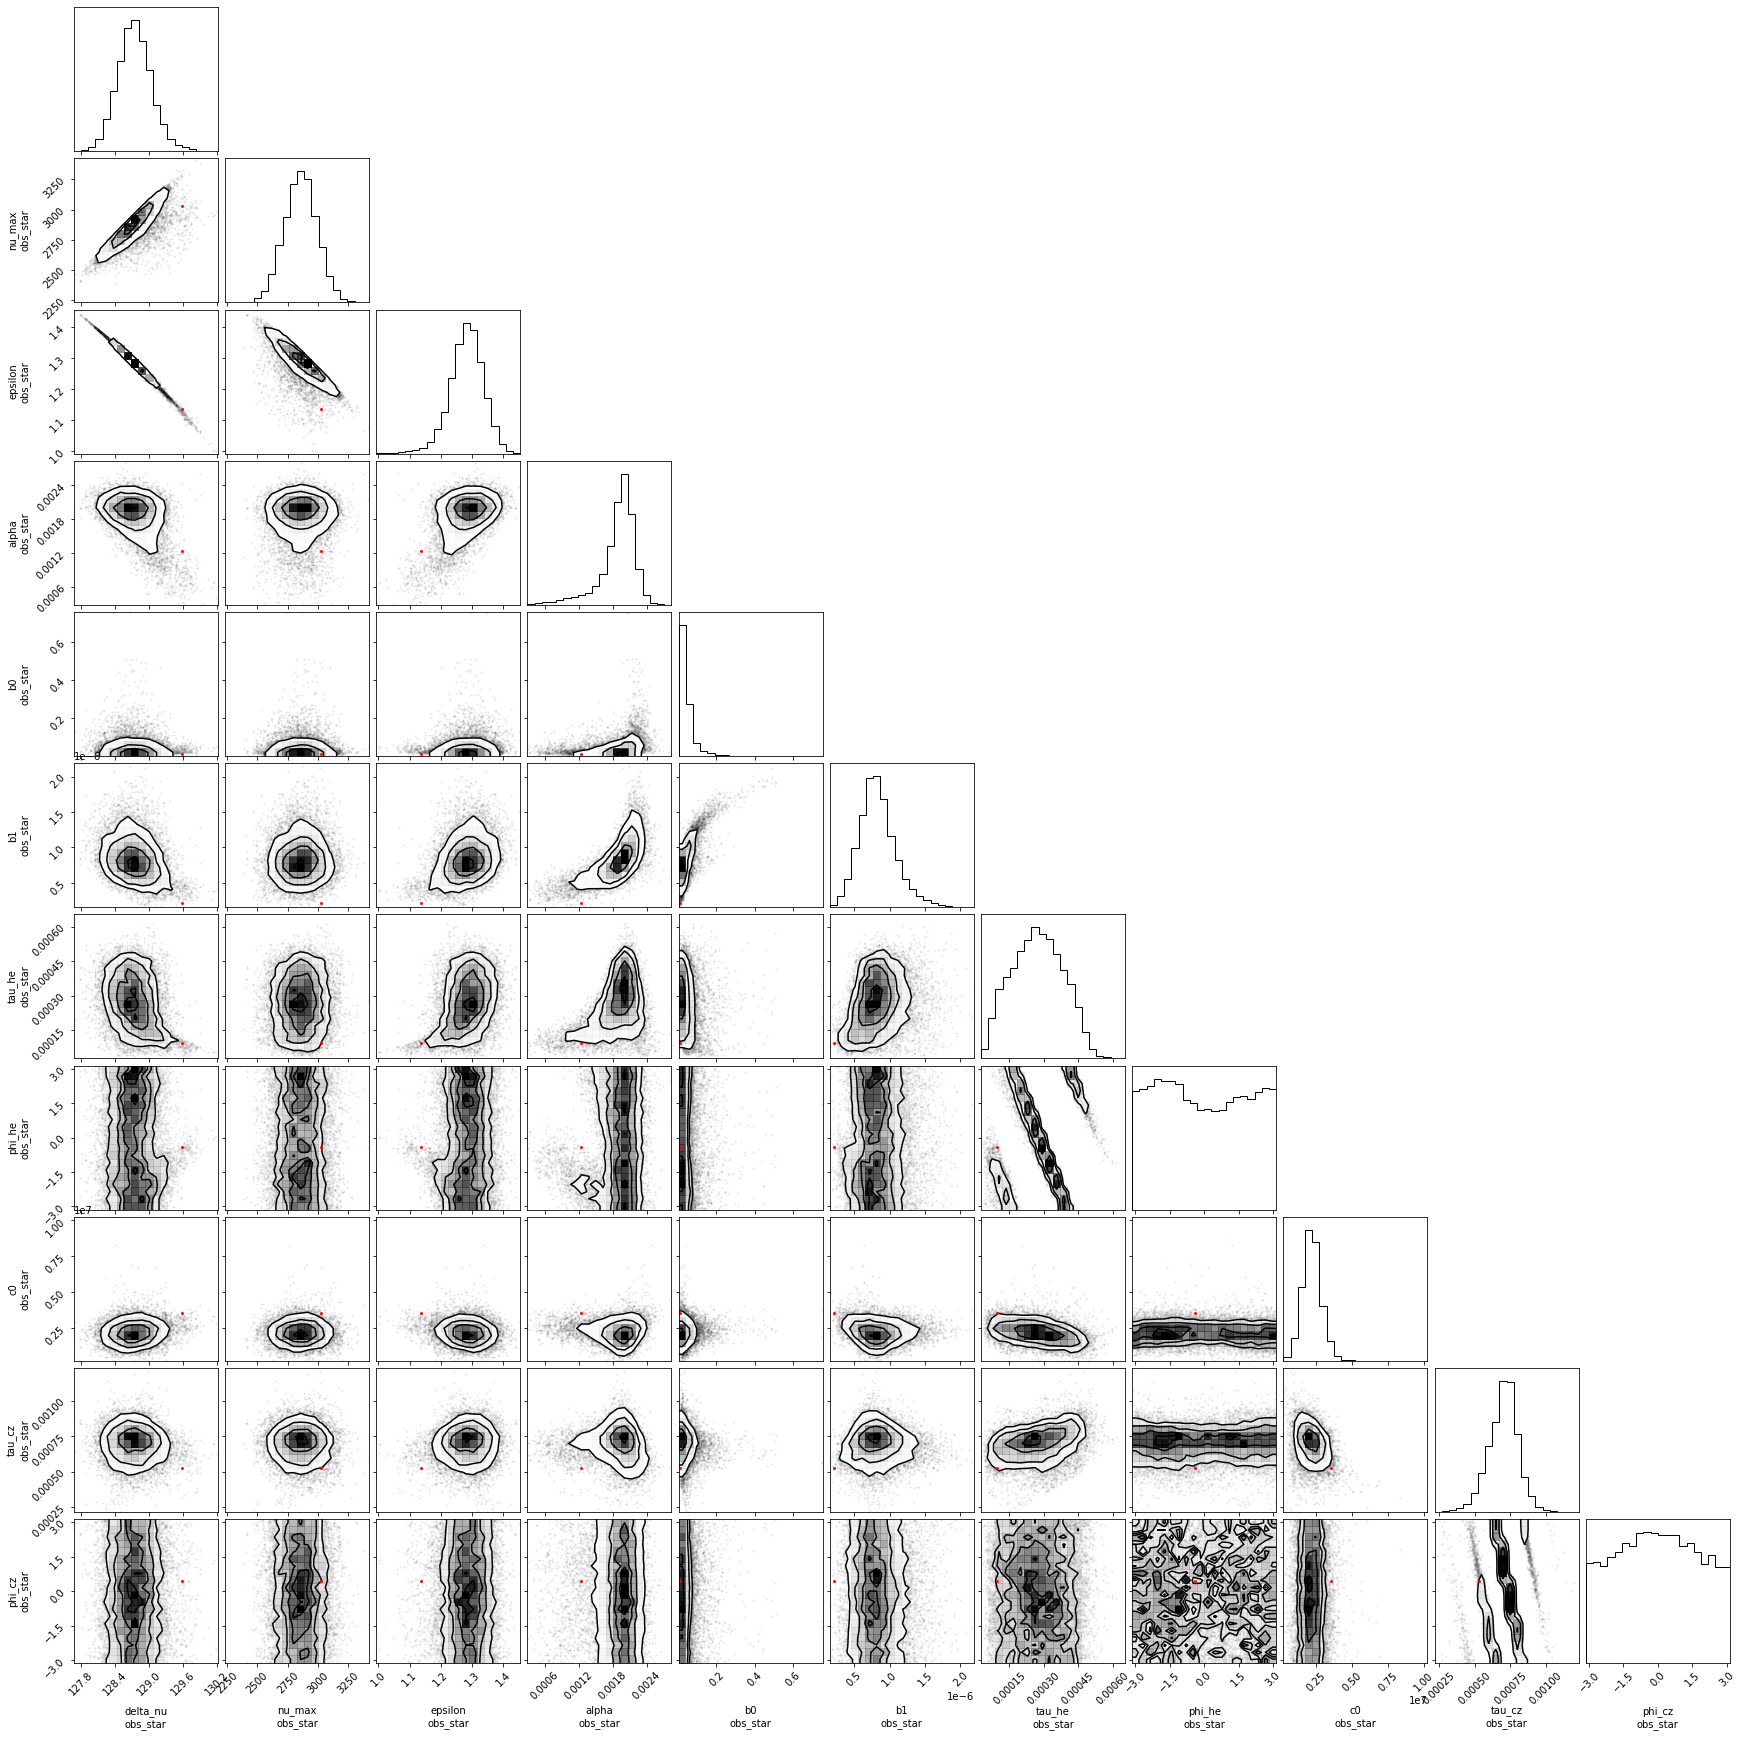

In [122]:
corner(
    infer.data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

#### Predictions

Finally, let's make some predictions from our posterior samples. This will be a continuous function of `n`.

In [123]:
infer.predictions()

We can view our inference data interactively.

In [124]:
infer.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data

Let's look at the predictions.

In [140]:
post = infer.data.posterior
post

<xarray.Dataset>
Dimensions:                 (chain: 5, draw: 2000, n: 20, name: 1, phi_cz_unwrapped_dim_0: 1, phi_he_unwrapped_dim_0: 1)
Coordinates:
  * chain                   (chain) int64 0 1 2 3 4
  * draw                    (draw) int64 0 1 2 3 4 ... 1995 1996 1997 1998 1999
  * name                    (name) <U8 'obs_star'
  * n                       (n) int64 10 11 12 13 14 15 16 ... 24 25 26 27 28 29
  * phi_cz_unwrapped_dim_0  (phi_cz_unwrapped_dim_0) int64 0
  * phi_he_unwrapped_dim_0  (phi_he_unwrapped_dim_0) int64 0
Data variables: (12/21)
    alpha                   (chain, draw, name) float64 0.001946 ... 0.002285
    b0                      (chain, draw, name) float64 0.01173 ... 0.1151
    b1                      (chain, draw, name) float64 6.398e-07 ... 1.075e-06
    c0                      (chain, draw, name) float64 2.183e+06 ... 2.436e+06
    delta_nu                (chain, draw, name) float64 128.4 128.2 ... 128.8
    delta_tau               (chain, draw, name) float64 0.0005054 ... 0.0006077
    ...                      ...
    phi_cz                  (chain, draw, name) float64 2.734 1.48 ... 2.894
    phi_cz_unwrapped        (chain, draw, phi_cz_unwrapped_dim_0) float64 -9....
    phi_he                  (chain, draw, name) float64 -1.919 -2.789 ... -1.22
    phi_he_unwrapped        (chain, draw, phi_he_unwrapped_dim_0) float64 -1....
    tau_cz                  (chain, draw, name) float64 0.0008588 ... 0.0006464
    tau_he                  (chain, draw, name) float64 0.0003534 ... 3.872e-05
Attributes:
    created_at:     2021-08-10T15:49:03.106980
    arviz_version:  0.11.2

In [141]:
pred = infer.data.predictions
pred

<xarray.Dataset>
Dimensions:  (chain: 5, draw: 2000, n_pred: 200, name: 1)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * name     (name) <U8 'obs_star'
  * n_pred   (n_pred) float64 10.0 10.1 10.19 10.29 ... 28.71 28.81 28.9 29.0
Data variables:
    dnu_cz   (chain, draw, name, n_pred) float64 -0.2686 -0.1377 ... -0.01193
    dnu_he   (chain, draw, name, n_pred) float64 -4.31 -4.267 ... 2.124e-05
    nu       (chain, draw, name, n_pred) float64 1.464e+03 ... 3.907e+03
    nu_asy   (chain, draw, name, n_pred) float64 1.468e+03 ... 3.907e+03
    tau_cz   (chain, draw, name) float64 0.0008588 0.0009027 ... 0.0006464
Attributes:
    created_at:     2021-08-10T15:49:03.500556
    arviz_version:  0.11.2

In [142]:
glitch = post["dnu_he"] + post["dnu_cz"]

In [143]:
glitch_pred = pred["dnu_he"] + pred["dnu_cz"]  # Add both glitches

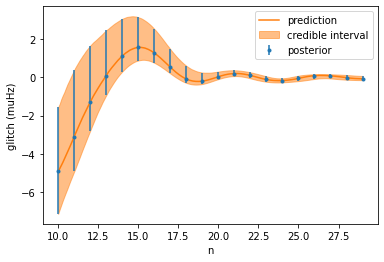

In [144]:
dim = ["chain", "draw"]  # Dimensions to calculate stats over
name = "obs_star"      # Name of star to plot

glitch_med = glitch.sel(name=name).median(dim=dim)
upper = glitch.sel(name=name).quantile(.84, dim=dim)
lower = glitch.sel(name=name).quantile(.16, dim=dim)

plt.errorbar(
    glitch["n"], 
    glitch_med,
    yerr=[
        glitch_med-lower,
        upper-glitch_med,
    ],
    fmt='.',
    label='posterior',
)

plt.plot(
    glitch_pred["n_pred"], 
    glitch_pred.sel(name=name).median(dim=dim),
    label='prediction'
)
plt.fill_between(
    glitch_pred["n_pred"], 
    glitch_pred.sel(name=name).quantile(.16, dim=dim),
    glitch_pred.sel(name=name).quantile(.84, dim=dim),
    alpha=0.5,
    color='C1',
    label='credible interval',
)

plt.xlabel('n')
plt.ylabel('glitch (muHz)')
plt.legend();

In [131]:
save(infer.data, 'example_obs.trace')

'example_obs.trace'

## EXPERIMENTAL STUFF BELOW

In [22]:
# guide = numpyro.infer.autoguide.AutoDiagonalNormal(posterior, init_loc_fn=init_strategy)
# optim = Adam(step_size=1e-3)
# loss = Trace_ELBO()
# svi = SVI(prior, guide, optim, loss)

In [23]:
# rng_seed, rng_key = random.split(rng_seed)

In [24]:
# svi_result = svi.run(rng_key, 50000)

In [25]:
# neutra = numpyro.infer.reparam.NeuTraReparam(guide, svi_result.params)

In [26]:
# posterior = neutra.reparam(posterior)

In [27]:
nuts = NUTS(posterior, target_accept_prob=0.99, init_strategy=init_strategy)
mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [28]:
rng_seed, rng_key = random.split(rng_seed)

In [29]:
mcmc.run(rng_key)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                alpha      0.00      0.00      0.00      0.00      0.00     25.02      1.17
                   b0      0.02      0.02      0.02      0.00      0.05    184.36      1.03
                   b1      0.00      0.00      0.00      0.00      0.00     74.56      1.06
                   c0 2265333.63 729878.18 2236814.35 1044195.79 3390466.98    128.78      1.04
             delta_nu    128.79      0.35    128.76    128.23    129.30     45.94      1.10
            delta_tau      0.00      0.00      0.00      0.00      0.00    153.14      1.03
              epsilon      1.28      0.06      1.28      1.18      1.37     46.03      1.11
                  err      0.10      0.04      0.09      0.03      0.16    430.45      1.01
               nu_max   2830.03    132.51   2831.27   2606.65   3034.33    287.61      1.02
 nu_obs_unobserved[0]  25692.65  80169.47   7488.40 -80763.10 174971.27    

In [31]:
group_by_chain = True
posterior_samples = mcmc.get_samples(group_by_chain=group_by_chain)
sample_stats = mcmc.get_extra_fields(group_by_chain=group_by_chain)

In [32]:
group_dict={
    'posterior': posterior_samples,
    'sample_stats': sample_stats,
}

In [33]:
trace.add_groups(**group_dict)

In [34]:
var_names = ['delta_nu', 'nu_max', 'epsilon', 'alpha', 
             'b0', 'b1', 'tau_he', 'phi_he', 
             'c0', 'tau_cz', 'phi_cz', 'he_nu_max']

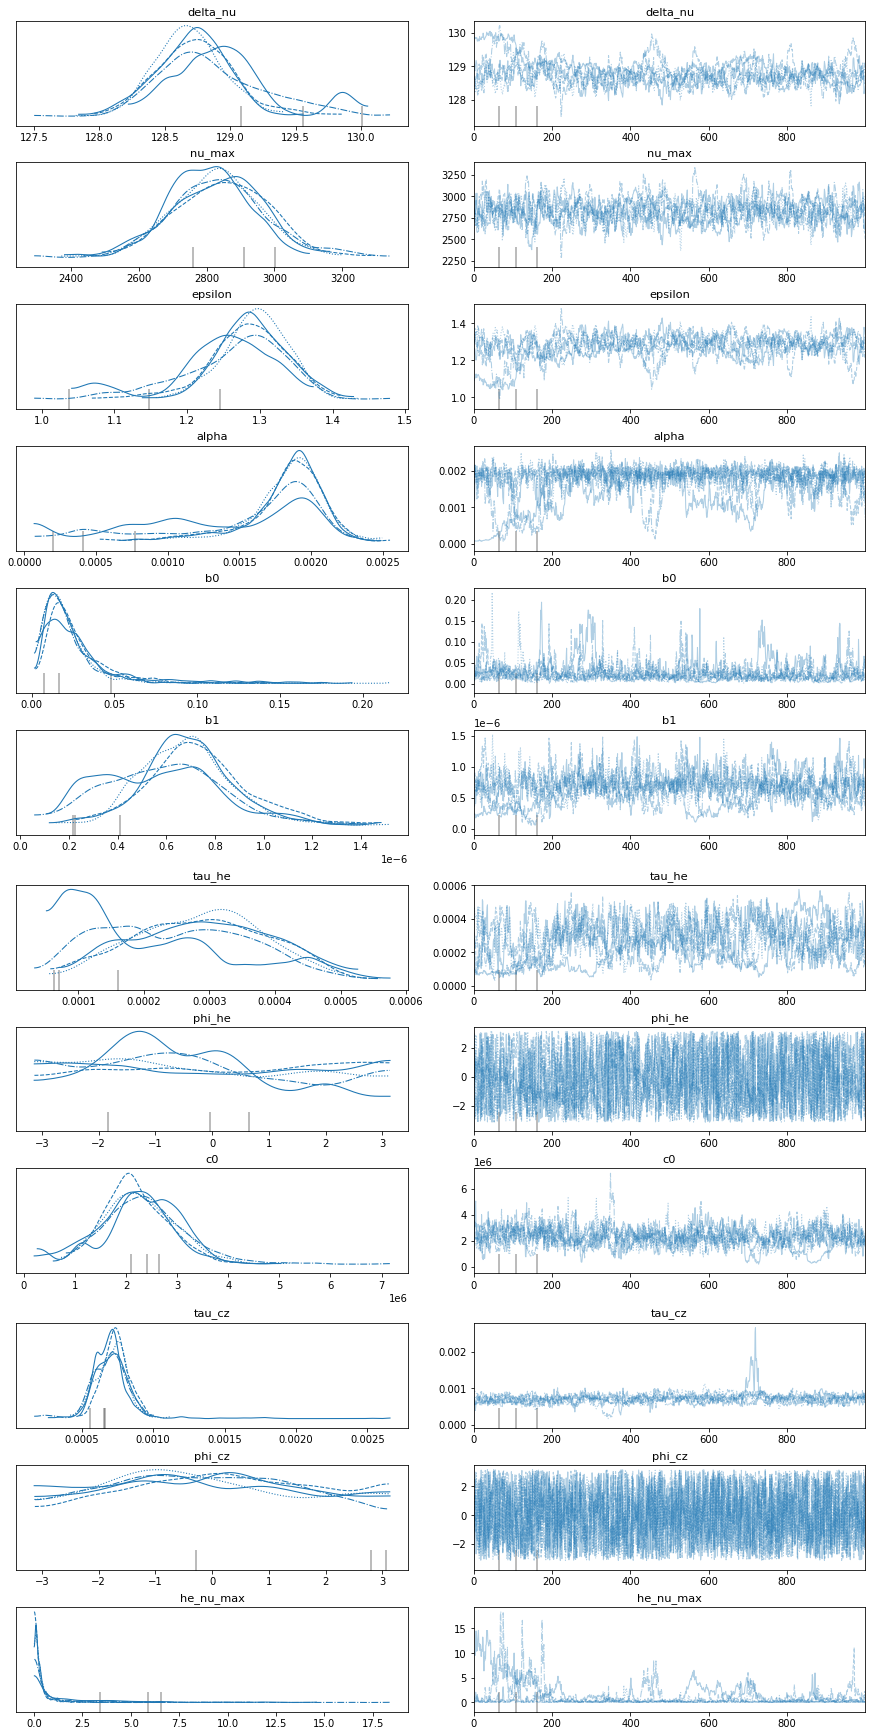

In [35]:
az.plot_trace(trace, var_names=var_names);

(array([   5.,   20.,   45.,  234.,  602., 1495., 1333.,  661.,  460.,
         145.]),
 array([-3.45077798, -2.97920969, -2.50764141, -2.03607312, -1.56450484,
        -1.09293655, -0.62136826, -0.14979998,  0.32176831,  0.79333659,
         1.26490488]),
 <BarContainer object of 10 artists>)

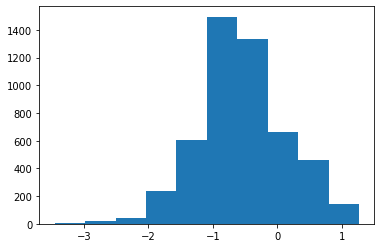

In [36]:
plt.hist(np.log10(posterior_samples['he_nu_max']).flatten())

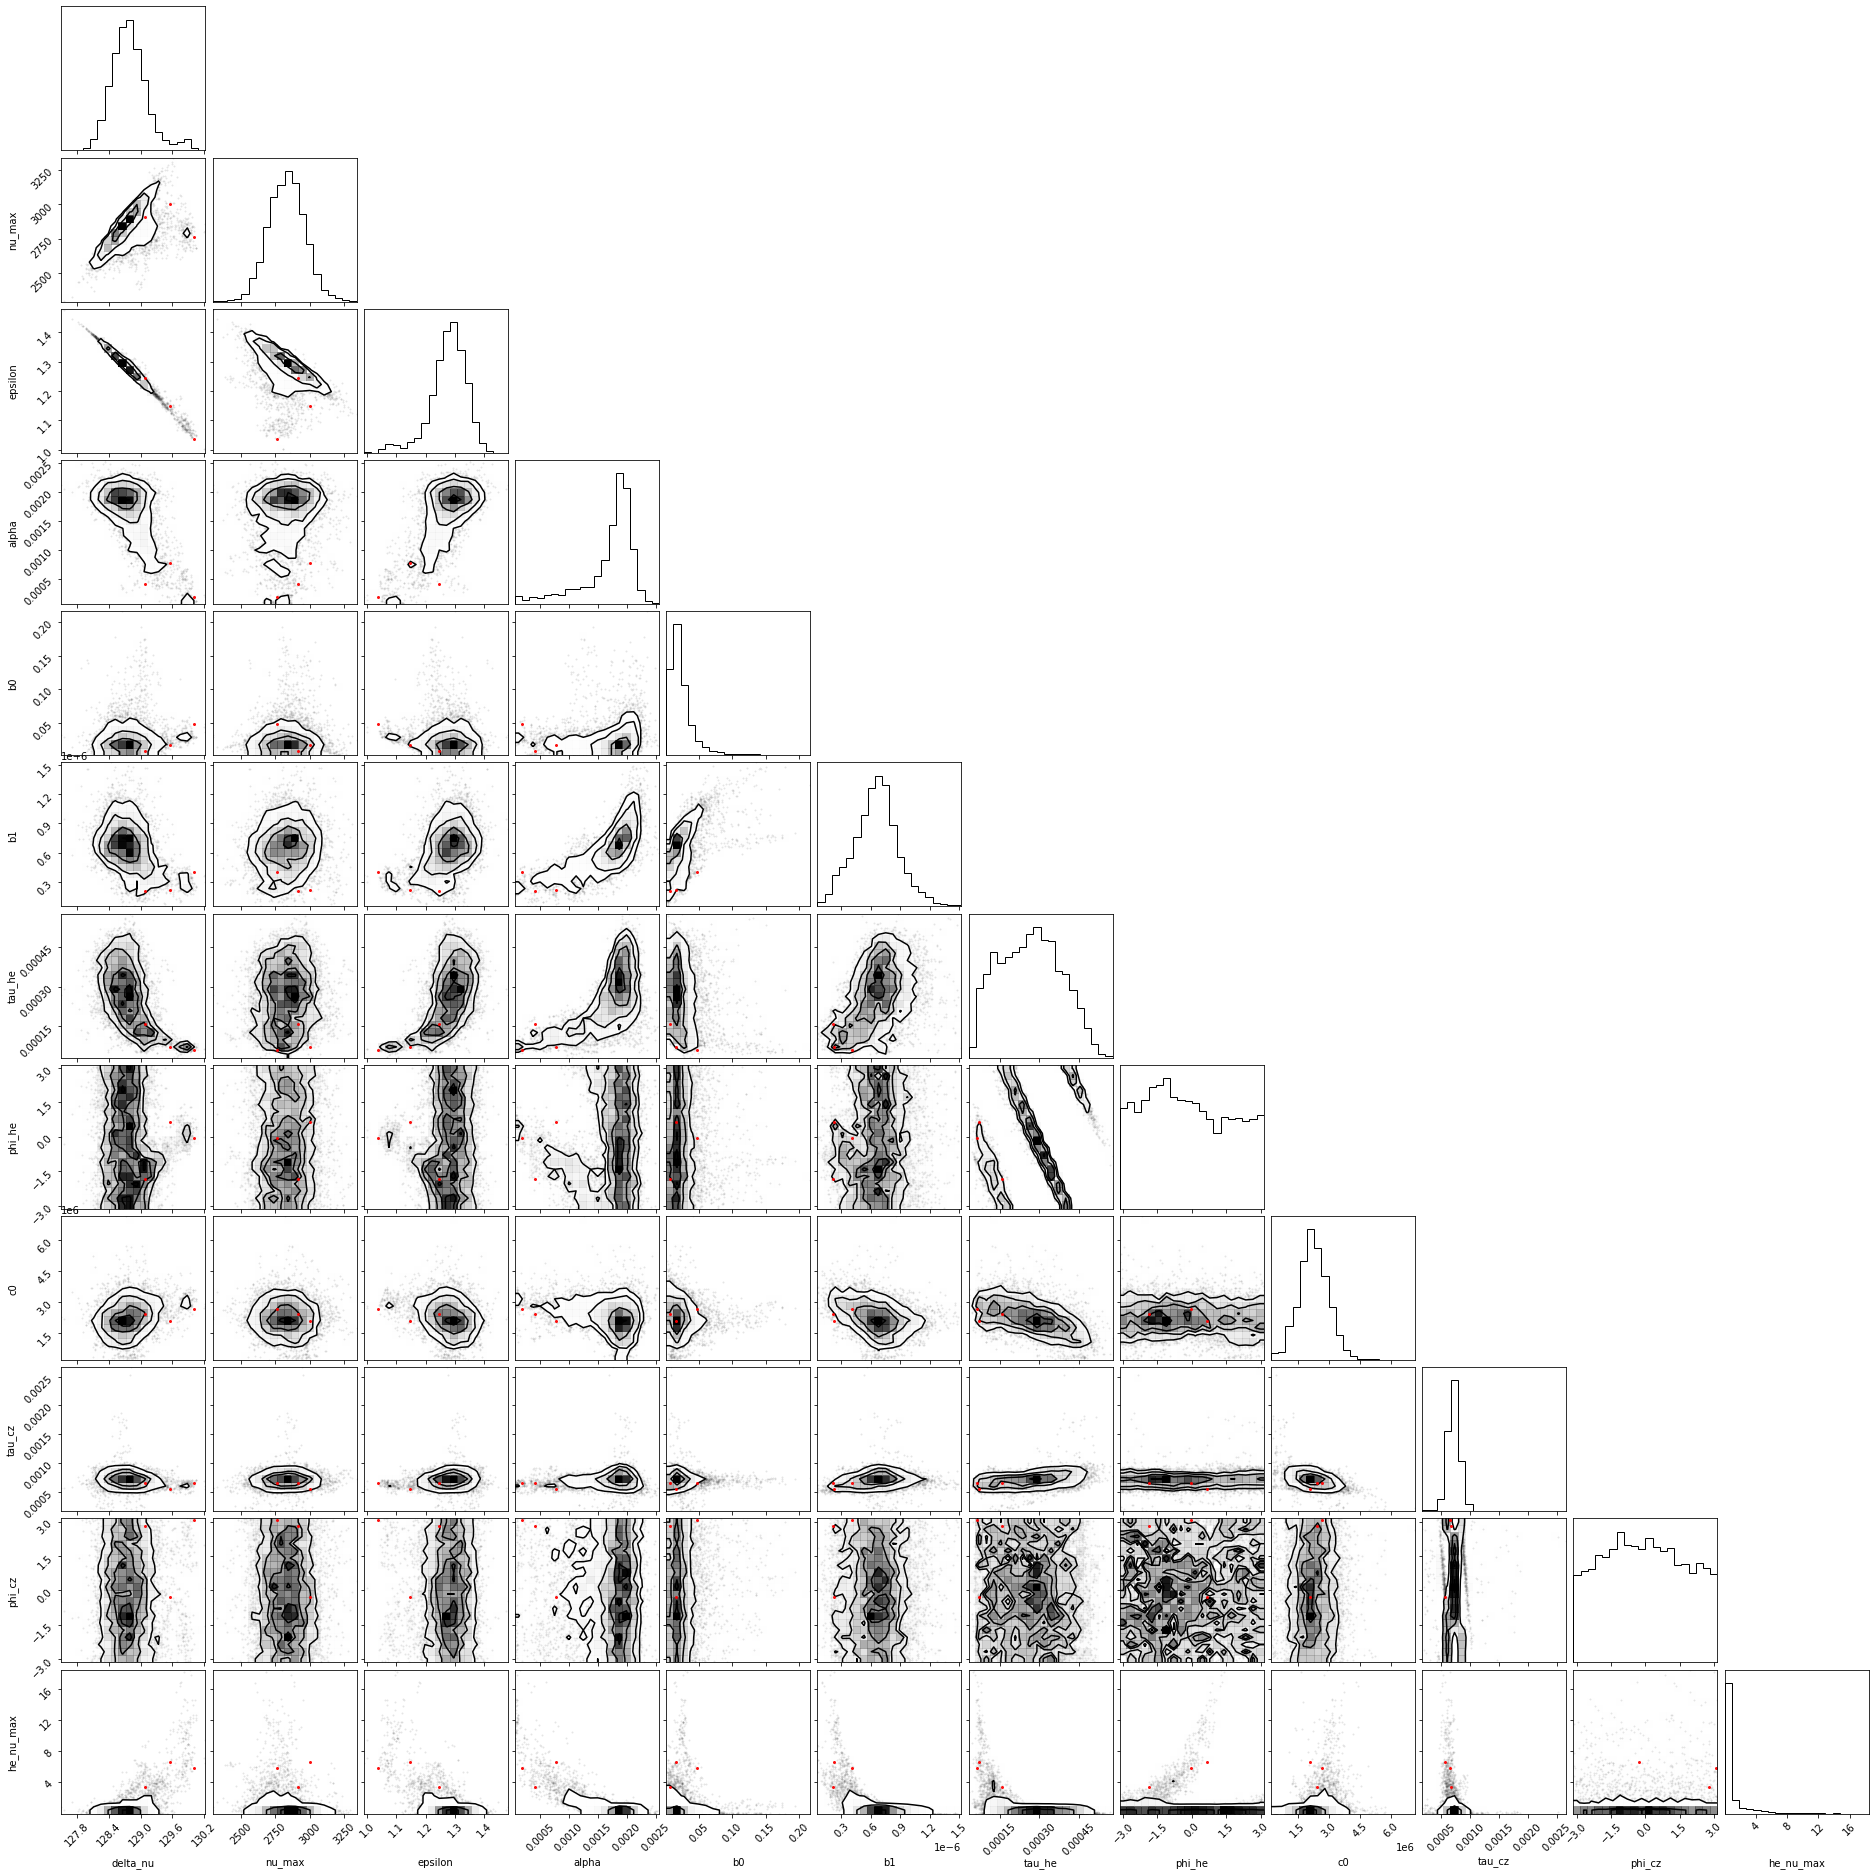

In [37]:
corner(
    trace, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

In [ ]:
trace.posterior.to_array()

In [50]:
posterior_predictive = Predictive(glitch.prior, posterior_samples=posterior_samples, batch_ndims=2)

In [51]:
rng_seed, rng_key = random.split(rng_seed)

In [52]:
posterior_predictive_samples = posterior_predictive(rng_key)

In [53]:
trace.add_groups(group_dict={
    'posterior_predictive': posterior_predictive_samples
})

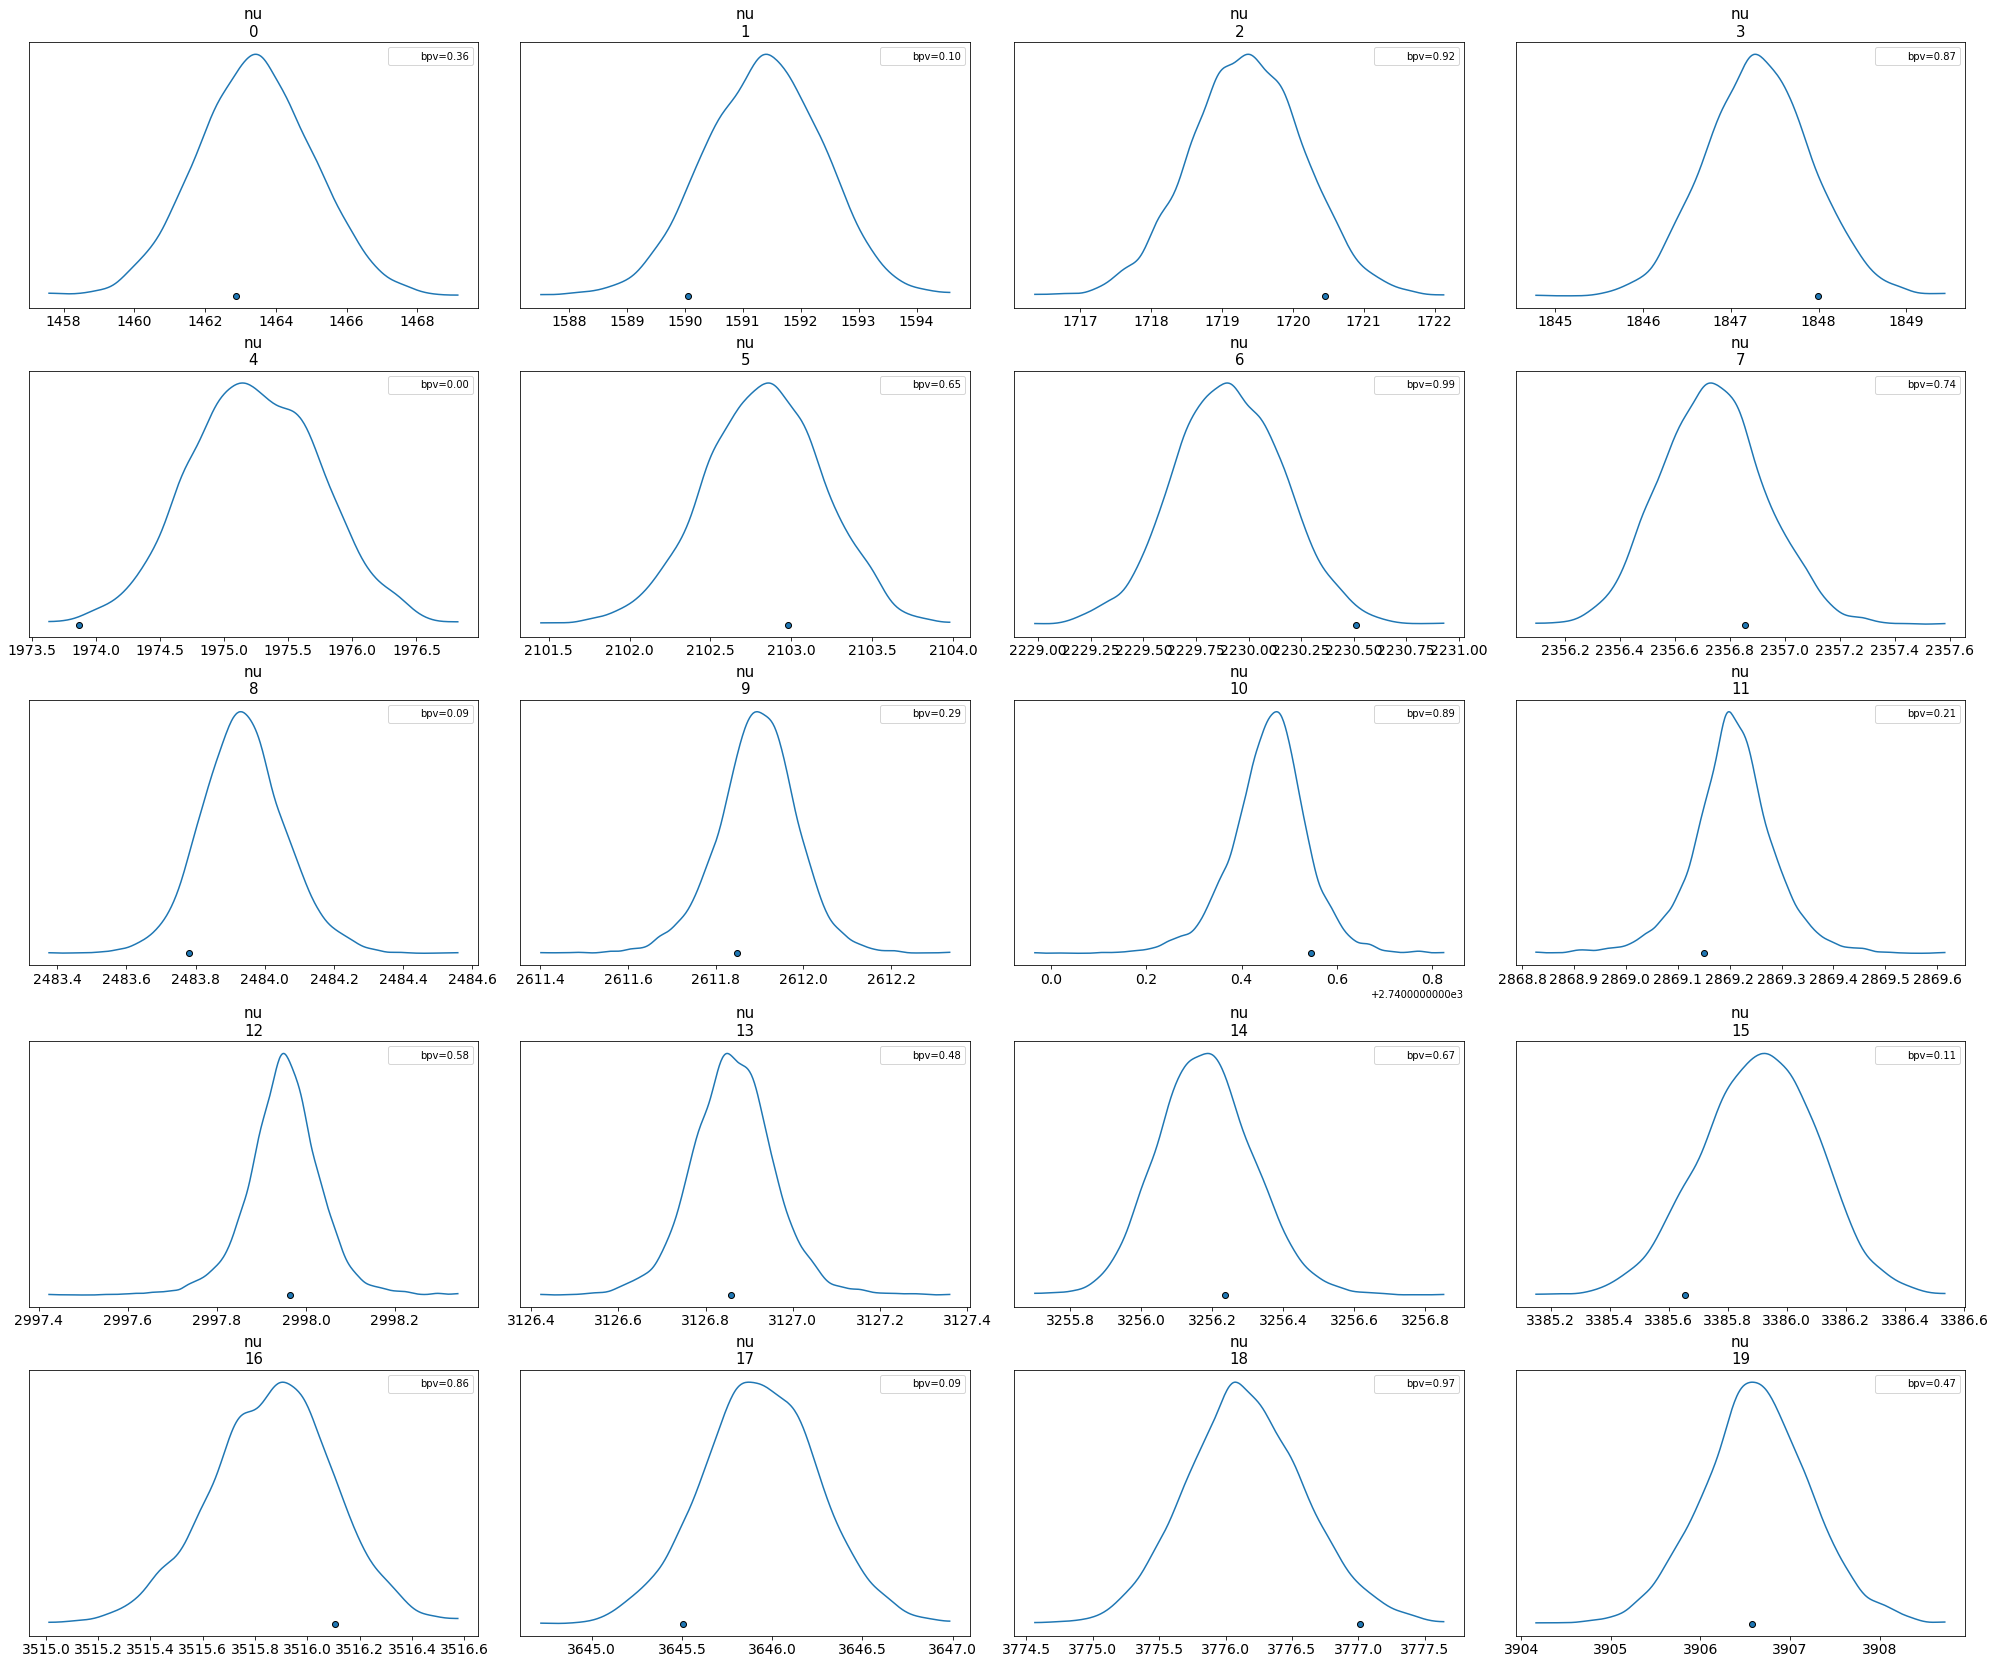

In [54]:
ax = az.plot_bpv(trace, group='posterior', kind='t_stat', flatten=['chain', 'draws']);

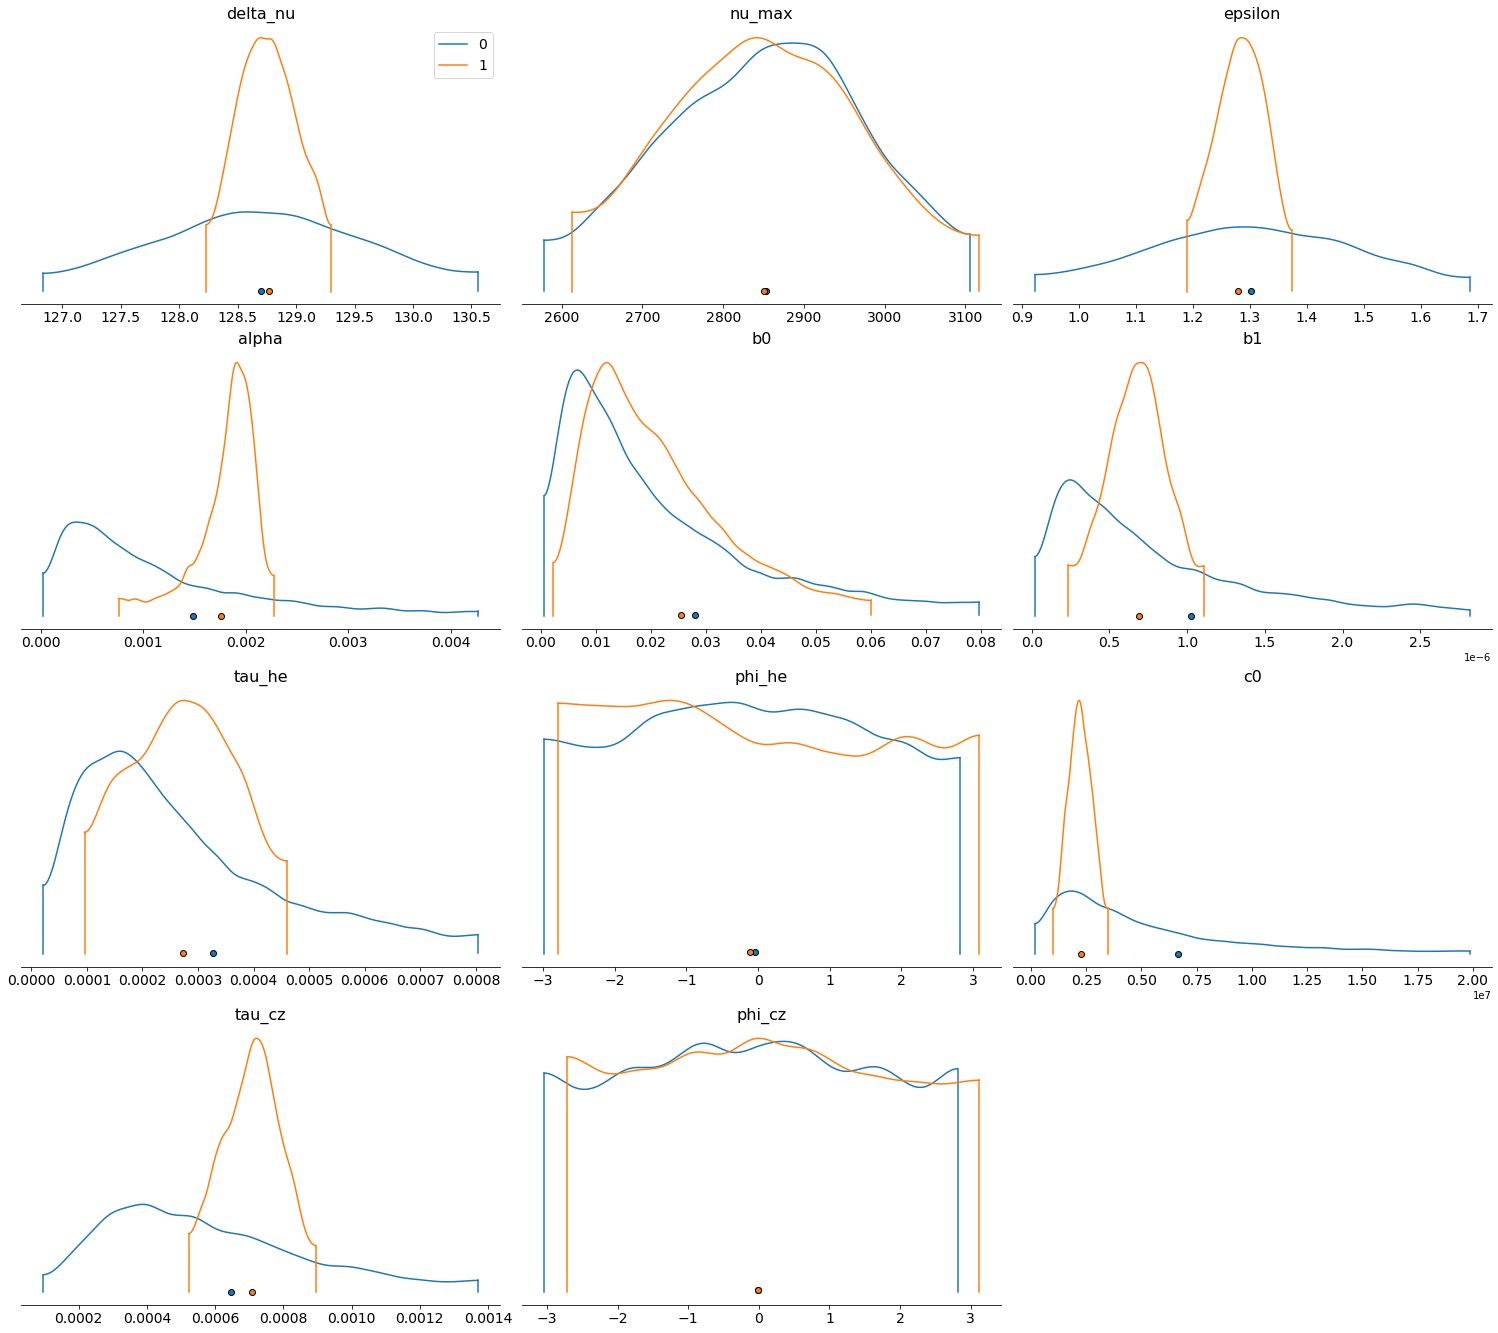

In [58]:
az.plot_density([trace.prior_predictive, trace.posterior], var_names=var_names);

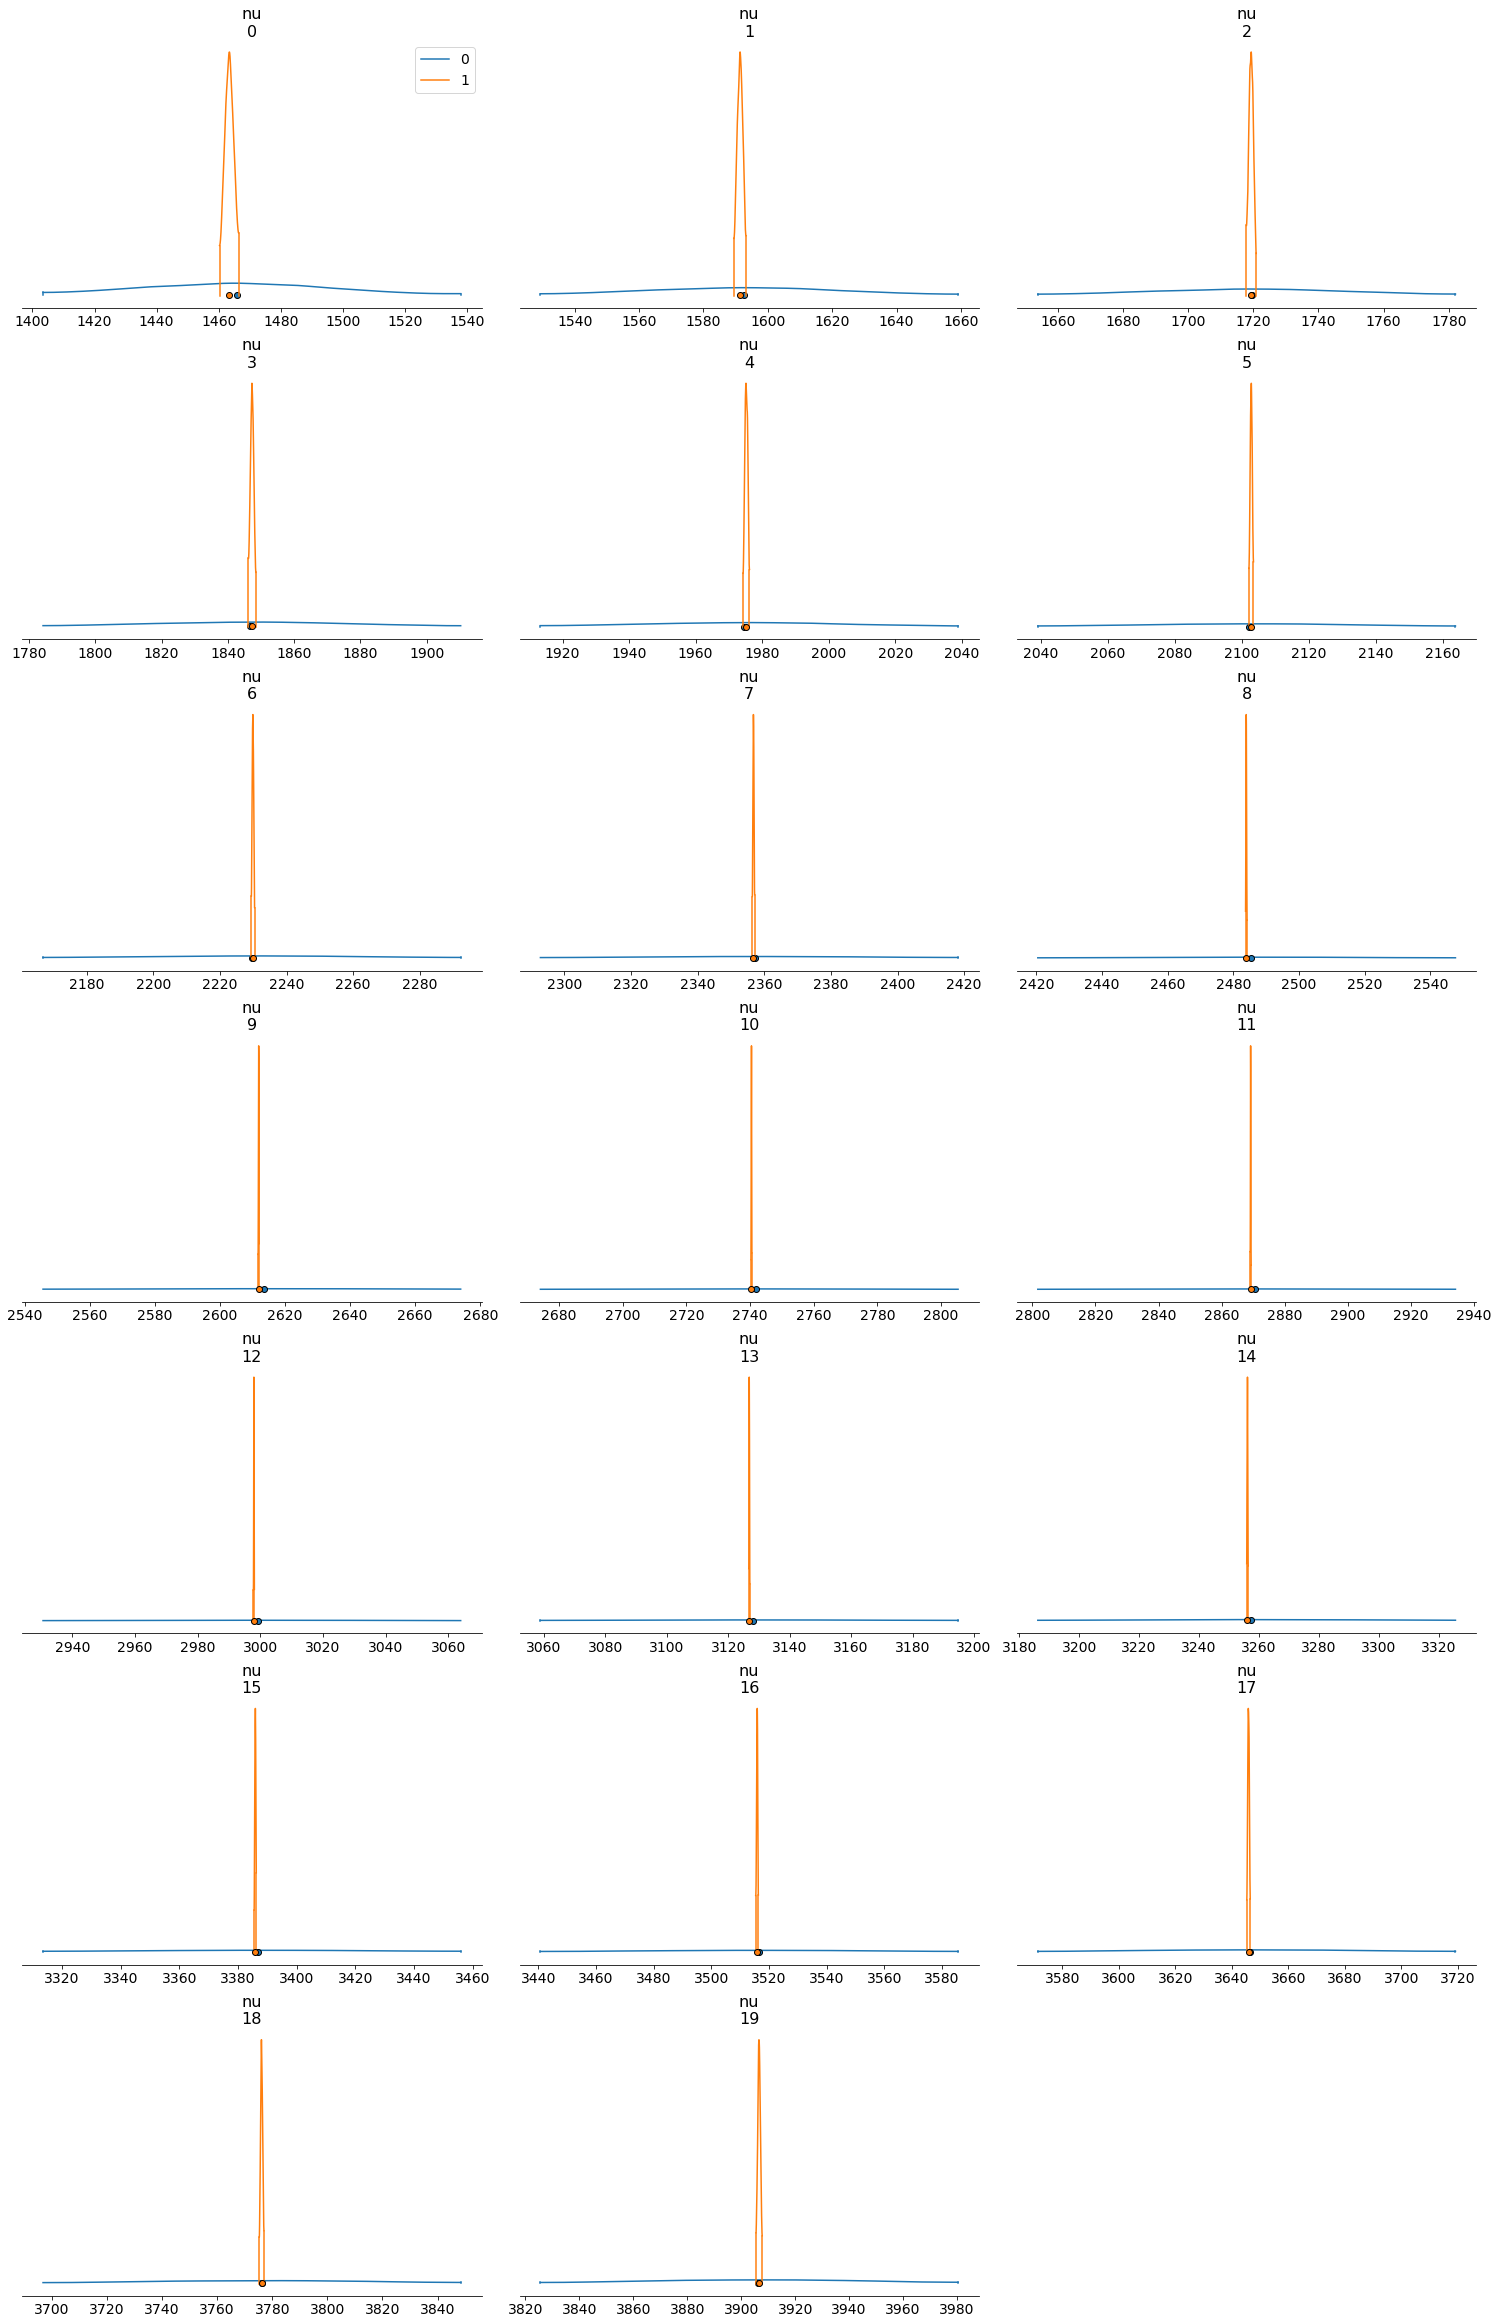

In [59]:
az.plot_density([trace.prior_predictive, trace.posterior_predictive], var_names=['nu']);

In [61]:
predictions = Predictive(glitch.predictions, posterior_samples=posterior_samples, batch_ndims=2)

In [62]:
rng_seed, rng_key = random.split(rng_seed)
prediction_samples = predictions(rng_key)

In [71]:
trace = az.from_dict(
    posterior=posterior_samples,
    posterior_predictive=posterior_predictive_samples,
    predictions=prediction_samples,
    sample_stats=sample_stats,
    prior_predictive=prior_predictive_samples,
    observed_data=glitch.observed_data,
    constant_data=glitch.constant_data,
    predictions_constant_data=glitch.predictions_constant_data
)
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

In [151]:
def combine_chains(x):
    return jnp.reshape(x, (x.shape[0]*x.shape[1], *x.shape[2:]))

In [154]:
n = prior.n

nu_model = combine_chains(samples['nu'])
num_modes = nu_model.shape[1]

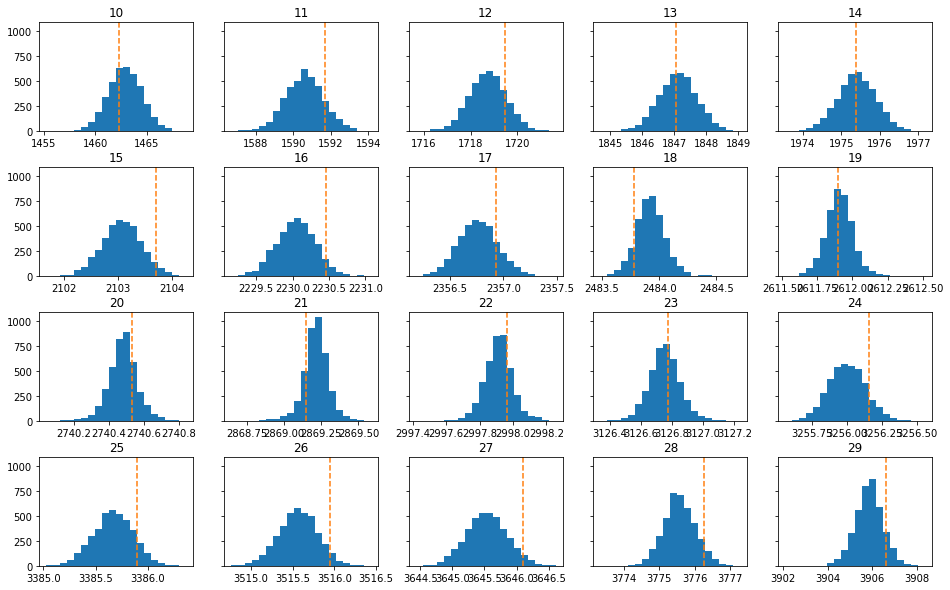

In [155]:
nrows = int(np.floor(np.sqrt(num_modes)))
ncols = int(np.ceil(num_modes/nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), sharey=True,
                        gridspec_kw={'hspace': .33})

for ax, nu_m, nu_t, _n in zip(np.ravel(axes), nu_model.T, nu, n):
    ax.hist(nu_m, bins=20, color='C0')
    ax.axvline(nu_t, color='C1', linestyle='--')
    ax.ticklabel_format(useOffset=False)
    ax.set_title(f'{_n}')